In [31]:
import pandas as pd
from maps.screens import ImageScreenMultiAntibody
from maps.multiantibody.config import TrainConfig, ModelConfig, DataLoaderConfig
import json
import torch
import umap

import sys
sys.path.append("/home/kkumbier/maps/")
import maps.multiantibody.data_loaders as data_loaders
import maps.multiantibody.models as models
import maps.multiantibody.training as training

# --- Initialize parameters ---
pdir = "/home/kkumbier/als/scripts/maps/template_analyses/params/"
with open(pdir + "maps_multiantibody-train.json", "r") as f:
    train_params = json.load(f)
    
with open(pdir + "maps_multiantibody-test.json", "r") as f:
    test_params = json.load(f)

dataloader_config = DataLoaderConfig()
train_config = TrainConfig()
model_config = ModelConfig()
model_config.n_classes = 2

antibodies = ["HSP70/SOD1", "FUS/EEA1"]
print(json.dumps(train_params, indent=4))


{
    "name": "maps_dmso",
    "screen": "20250216_AWALS37_Full_screen_n96",
    "root": "/awlab/projects/2024_ALS/Experiments",
    "data_file": "Objects_Population - Nuclei Selected.txt",
    "eval_dir": "Evaluation1",
    "preprocess": {
        "drop_na_features": {
            "na_prop": 0.1
        },
        "drop_sample_by_feature": {
            "drop_key": [
                {
                    "CellLines": [
                        "C9014",
                        "NS048"
                    ]
                }
            ]
        },
        "select_sample_by_feature": {
            "select_key": [
                {
                    "Drugs": [
                        "DMSO"
                    ],
                    "Mutations": [
                        "FUS",
                        "WT"
                    ],
                    "CellLines": [
                        "NS007",
                        "NS045",
                        "NS036",
                        "

In [32]:
# Load and process screens for train / test
train_screen = ImageScreenMultiAntibody(train_params)
train_screen.load(antibody=antibodies)

test_screen = ImageScreenMultiAntibody(test_params)
test_screen.load(antibody=antibodies)

print("Processing training set...")
train_screen.preprocess()

print("Processing test set...")
test_screen.preprocess()

for ab in  antibodies:
    print(f"Marker set: {ab}")
    print(f"Train data: {train_screen.data[ab].shape}")
    print(f"Test data: {test_screen.data[ab].shape}")

Processing training set...
Processing test set...
Marker set: HSP70/SOD1
Train data: (9187, 311)
Test data: (37603, 311)
Marker set: FUS/EEA1
Train data: (9458, 315)
Test data: (38177, 315)


In [33]:
import importlib
importlib.reload(data_loaders)
create_multiantibody_dataloader = data_loaders.create_multiantibody_dataloader


dataloader_config.batch_size = 6
train_dataloader = create_multiantibody_dataloader(
    train_screen,
    **vars(dataloader_config)
)

scalers = train_dataloader._get_scalers()
dataloader_config.mode = "eval"
test_dataloader = create_multiantibody_dataloader(
    test_screen,
    scalers=scalers,
    **vars(dataloader_config)
)

In [49]:
importlib.reload(training)
importlib.reload(models)
train = training.train
MultiAntibodyClassifier = models.MultiAntibodyClassifier

# Initiaize model and train
train_config.n_epochs = 100
train_config.patience = 100
train_config.lr = 1e-3

model_config.antibody_feature_dims = train_dataloader._get_feature_dims()
model_config.d_model = 16
model_config.n_layers = 1

model = MultiAntibodyClassifier(**vars(model_config))
train(model, train_dataloader, train_config)

Epoch 1/100, Cell Loss: 0.7544, Line Loss: 1.4835
  FUS/EEA1 - Cell Loss: 0.7589, Cell Acc: 0.4833
  HSP70/SOD1 - Cell Loss: 0.7499, Cell Acc: 0.5233
Epoch 2/100, Cell Loss: 0.7283, Line Loss: 1.1877
  FUS/EEA1 - Cell Loss: 0.6991, Cell Acc: 0.5800
  HSP70/SOD1 - Cell Loss: 0.7575, Cell Acc: 0.4933
Epoch 3/100, Cell Loss: 0.7207, Line Loss: 1.1692
  FUS/EEA1 - Cell Loss: 0.7278, Cell Acc: 0.5600
  HSP70/SOD1 - Cell Loss: 0.7136, Cell Acc: 0.5367
Epoch 4/100, Cell Loss: 0.7158, Line Loss: 1.2596
  FUS/EEA1 - Cell Loss: 0.6923, Cell Acc: 0.5867
  HSP70/SOD1 - Cell Loss: 0.7393, Cell Acc: 0.5267
Epoch 5/100, Cell Loss: 0.7021, Line Loss: 1.0843
  FUS/EEA1 - Cell Loss: 0.6803, Cell Acc: 0.5667
  HSP70/SOD1 - Cell Loss: 0.7238, Cell Acc: 0.5567
Epoch 6/100, Cell Loss: 0.6862, Line Loss: 1.0114
  FUS/EEA1 - Cell Loss: 0.6622, Cell Acc: 0.6400
  HSP70/SOD1 - Cell Loss: 0.7102, Cell Acc: 0.5267
Epoch 7/100, Cell Loss: 0.6962, Line Loss: 0.9733
  FUS/EEA1 - Cell Loss: 0.6557, Cell Acc: 0.5967
 

In [50]:
model.eval()
probs_line = []
probs_cell = {}
labels = []
cell_lines = []
embeddings = {}

device = next(model.parameters()).device  # Get device from model parameters
test_dataloader.batch_size
with torch.no_grad():
    for batch in test_dataloader:
        if batch is None:
            continue
        
        x_dict = {ab: batch[ab][0].to(device) for ab in batch}
        y_line = batch[list(batch.keys())[0]][1].to(device)
        cell_lines.extend([batch[list(batch.keys())[0]][-1]])

        cell_logits, line_logits, embs = model(
            x_dict, return_embedding=True
        )        
        
        labels.append(y_line.cpu())
        probs_line.append(torch.softmax(line_logits, dim=-1).cpu())

        for ab in cell_logits:
            if ab not in probs_cell:
                probs_cell[ab] = []        
            probs_cell[ab].append(torch.softmax(cell_logits[ab], dim=-1).cpu())
        
        for ab in embs:
            if not ab in embeddings:
                embeddings[ab] = []
            embeddings[ab].append(embs[ab].cpu())

# Merge outputs over cell lines
probs_line = torch.cat(probs_line)           
labels = torch.cat(labels)
probs_cell = {k: torch.cat(v).mean(dim=1) for k, v in probs_cell.items()}
embeddings = {k: torch.cat(v) for k, v in embeddings.items()}

In [51]:
# Create DataFrame with aggregate class probabilities from probs_line
df = pd.DataFrame({
    "class_0_agg": probs_line[:, 0].numpy(),
    "class_1_agg": probs_line[:, 1].numpy()
})

# Add per-antibody class probabilities from probs_cell
for ab in probs_cell:
    df[f"class_0_{ab}"] = probs_cell[ab][:, 0].numpy()
    df[f"class_1_{ab}"] = probs_cell[ab][:, 1].numpy()

df["CellLines"] = cell_lines
df["True"] = labels.numpy()

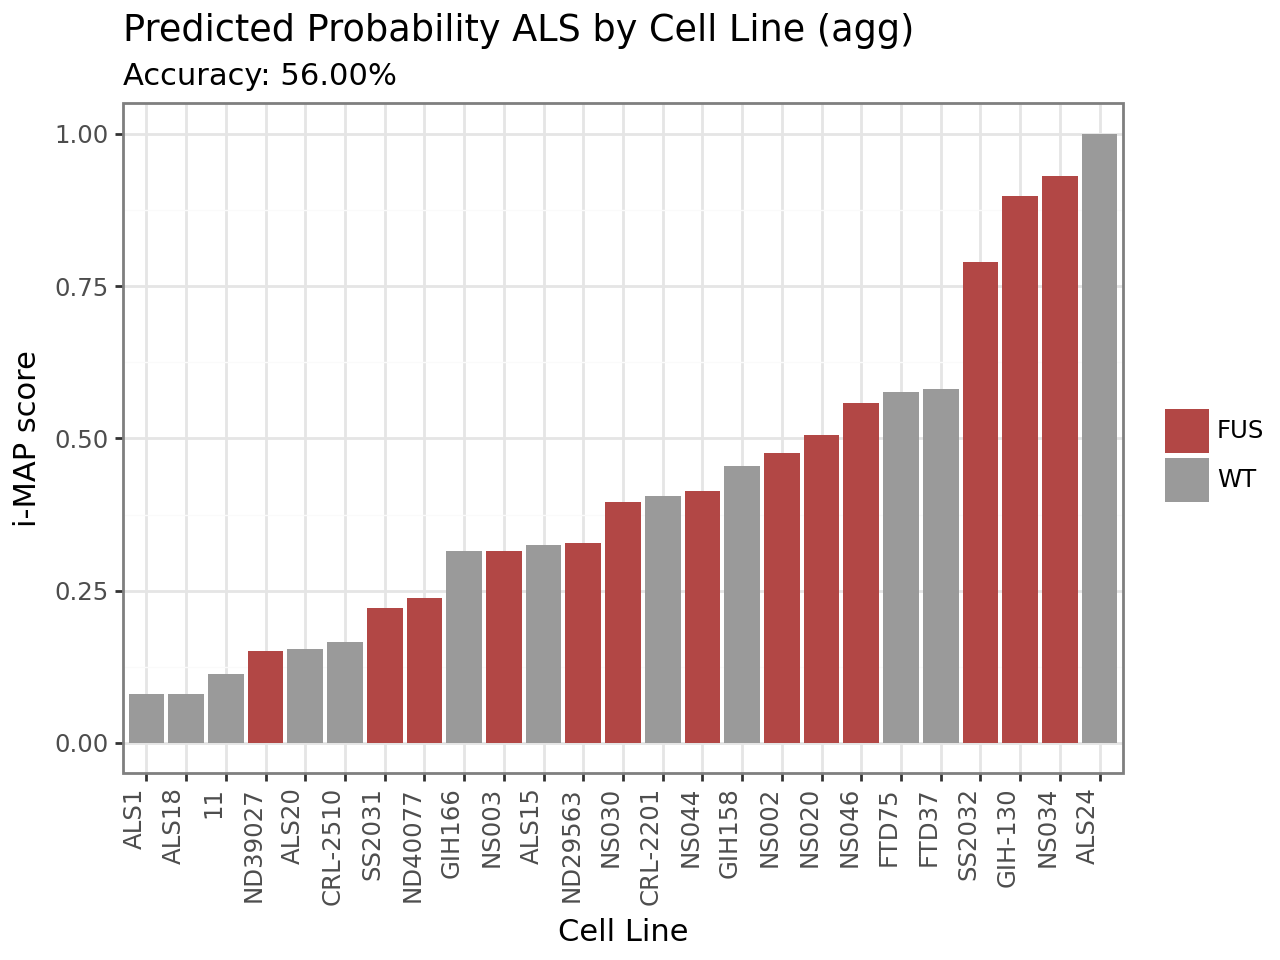

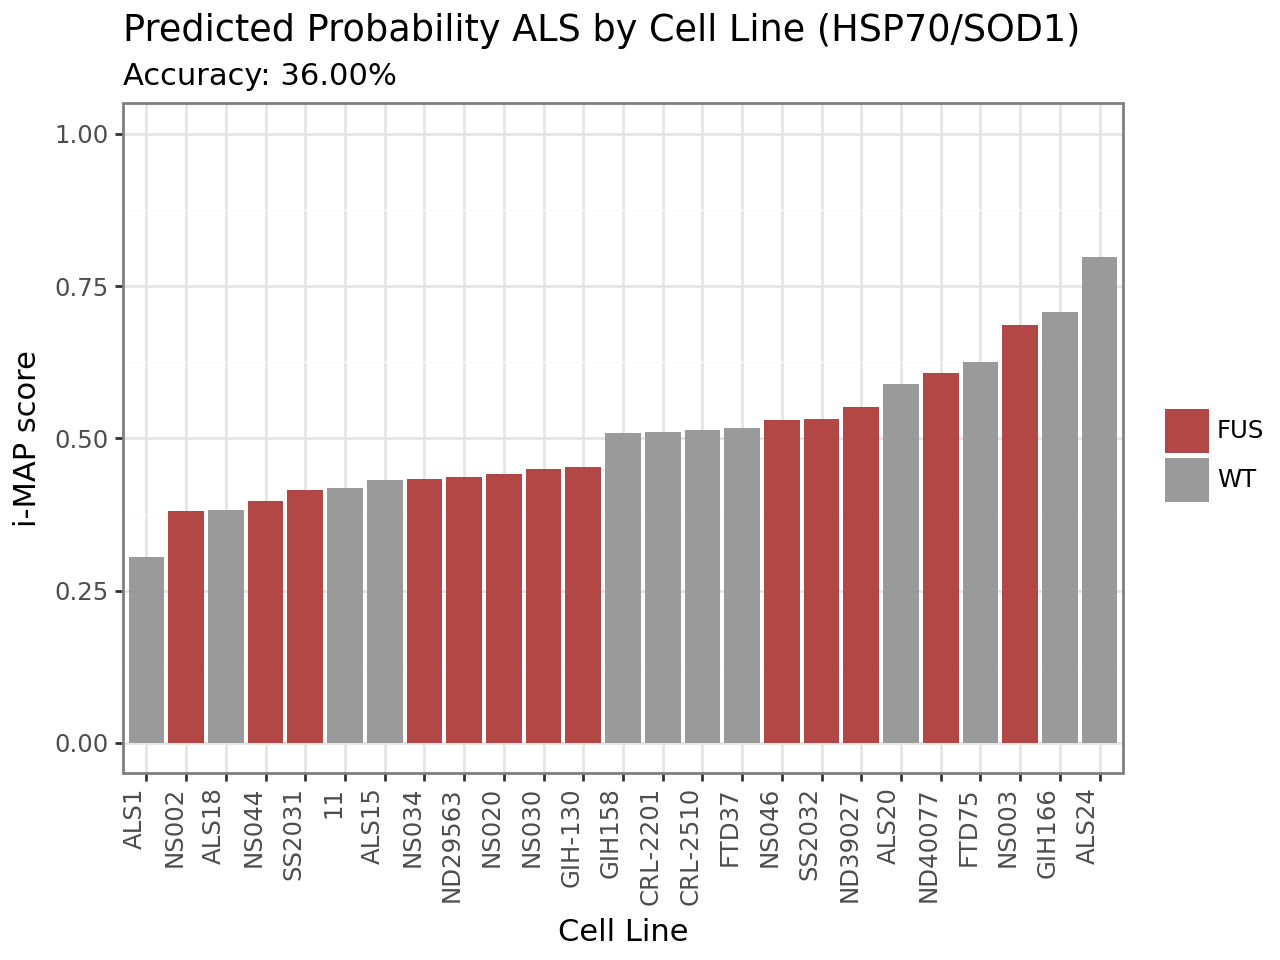

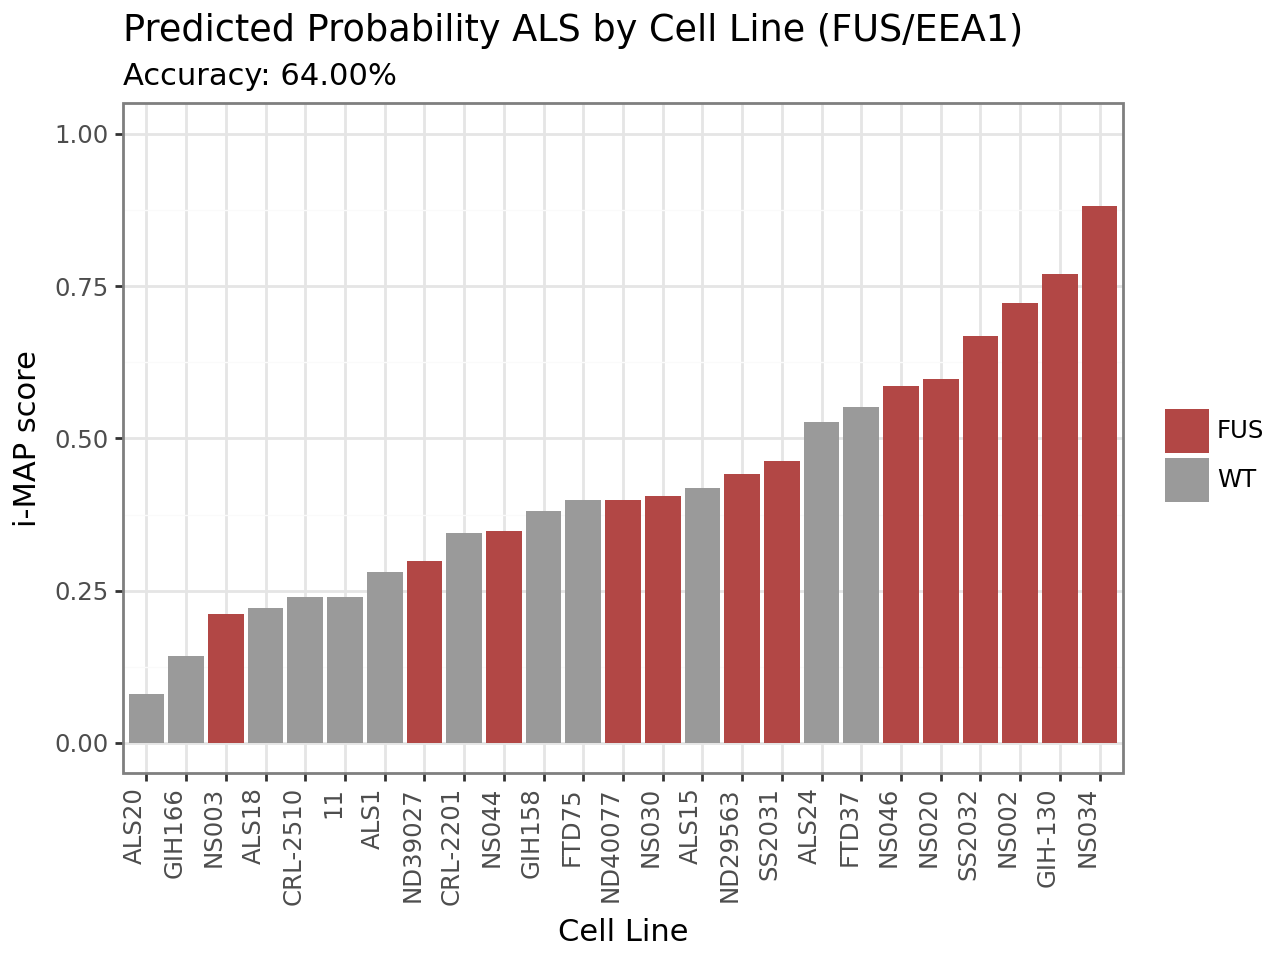

In [52]:
from IPython.display import display
from plotnine import ggplot, aes, geom_bar, theme, element_text, labs, ggtitle, scale_fill_manual, ylim, theme_bw
from maps.figures import PALETTE

label_key = {0: "WT", 1: "FUS"}
groups = ["agg"] + antibodies

for g in groups:
    # Sort preds by predicted probability (Class_1) in ascending order
    preds = df.sort_values(by=f'class_1_{g}', ascending=True)
    preds["True"] = preds["True"].map(label_key)
    
    preds['CellLines'] = pd.Categorical(
        preds['CellLines'], categories=preds['CellLines'], ordered=True
    )
    
    # Compute prediction accuracy for current group
    pred_labels = (preds[f'class_1_{g}'] > 0.5).map({True: "FUS", False: "WT"})
    accuracy = (pred_labels == preds["True"]).mean()
    
    p = (
        ggplot(preds, aes(x='CellLines', y=f'class_1_{g}', fill='True')) +
        geom_bar(stat='identity') +
        theme_bw() +
        theme(axis_text_x=element_text(rotation=90, hjust=1)) +
        labs(x='Cell Line', y='i-MAP score', fill="") +
        ggtitle(f"Predicted Probability ALS by Cell Line ({g})", subtitle=f"Accuracy: {accuracy:.2%}") +
        scale_fill_manual(values=PALETTE) +
        ylim(0, 1)
    )
    display(p)

/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


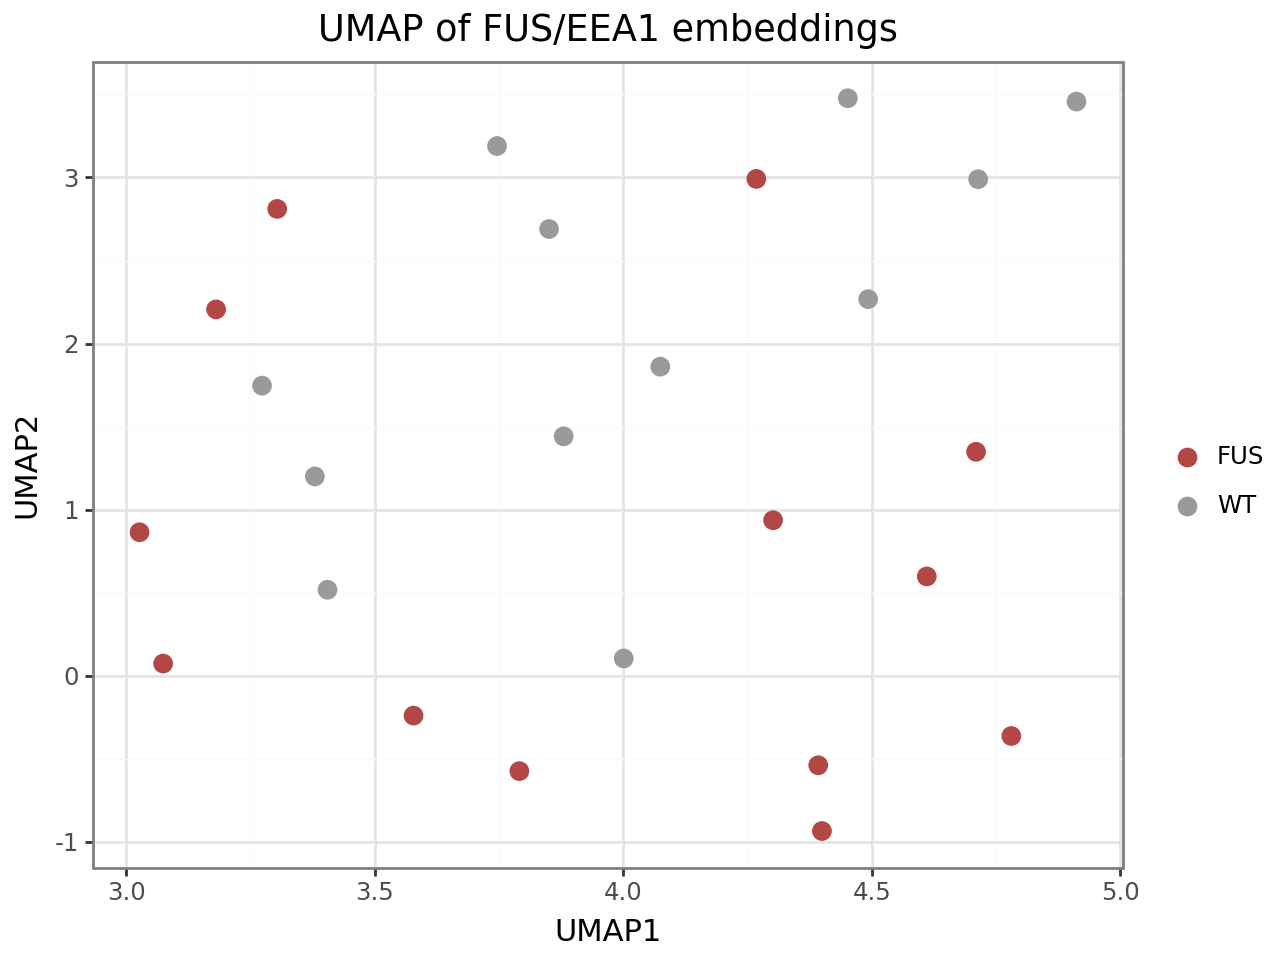

/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


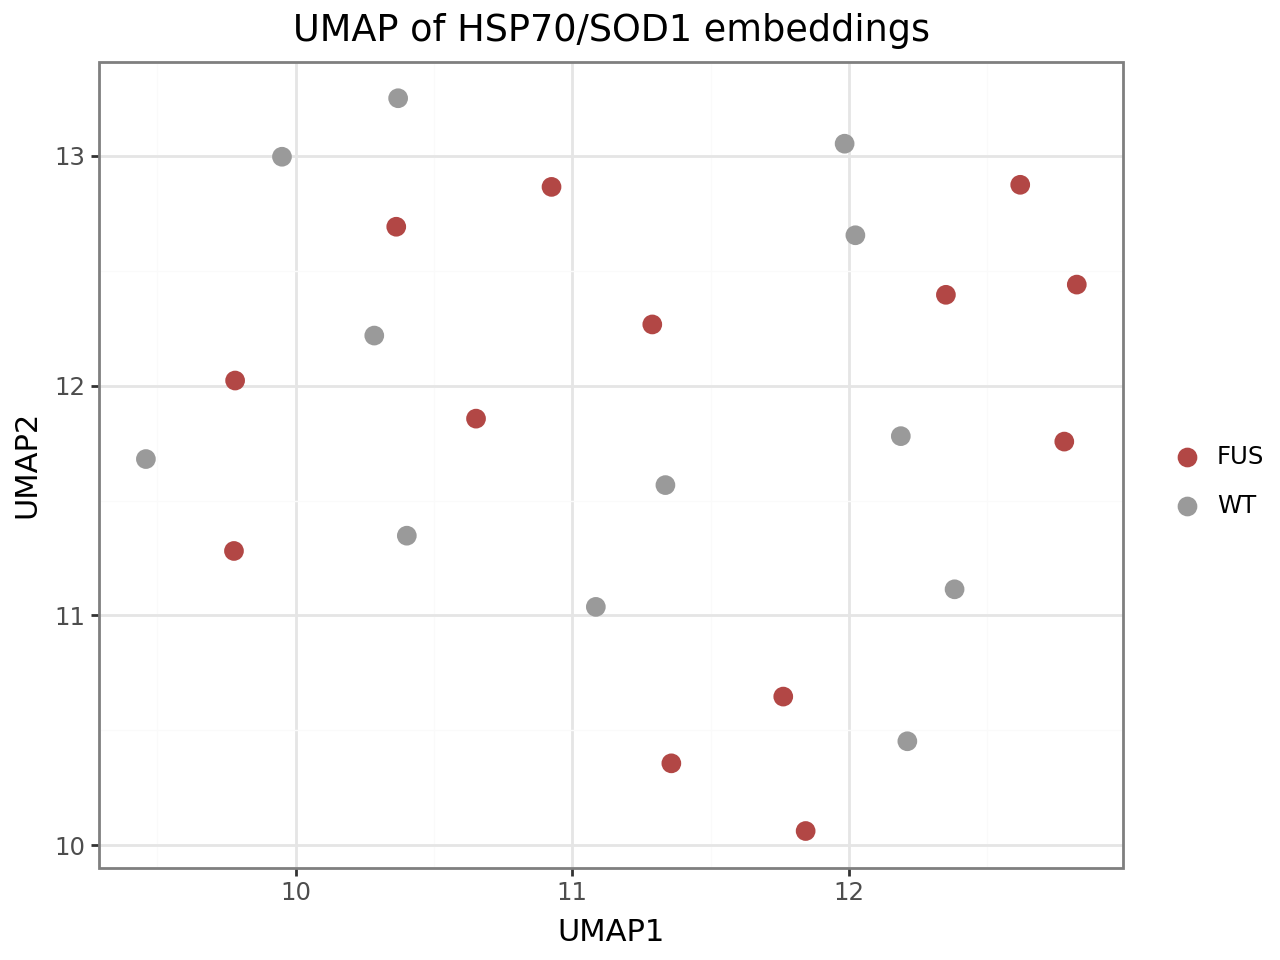

In [56]:
from plotnine import geom_point, scale_color_manual
label_key = {0: "WT", 1: "FUS"}
labels = df["True"].map(label_key).values

# Prepare DataFrame for individual antibody UMAPs
for ab, emb in embeddings.items():
    reducer = umap.UMAP(random_state=42)
    emb_2d = reducer.fit_transform(emb.cpu().numpy())
    df_umap = pd.DataFrame({
        "UMAP1": emb_2d[:, 0],
        "UMAP2": emb_2d[:, 1],
        "Label": labels
    })
    p = (
        ggplot(df_umap, aes(x="UMAP1", y="UMAP2", color="Label")) +
        geom_point(size=3) +
        scale_color_manual(values=PALETTE) +
        labs(color="") +
        ggtitle(f"UMAP of {ab} embeddings") +
        theme_bw()
    )
    
    display(p)

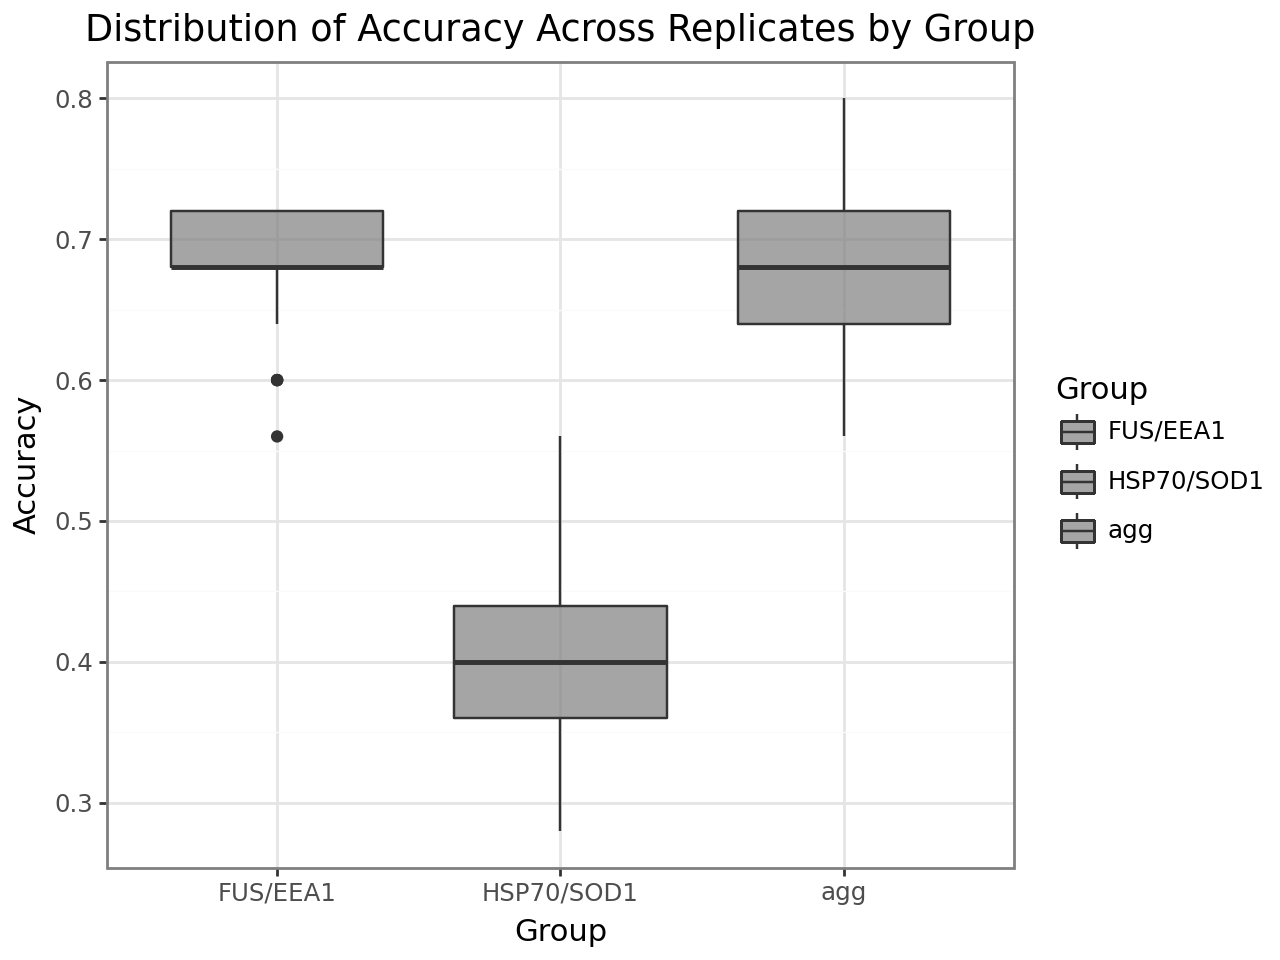

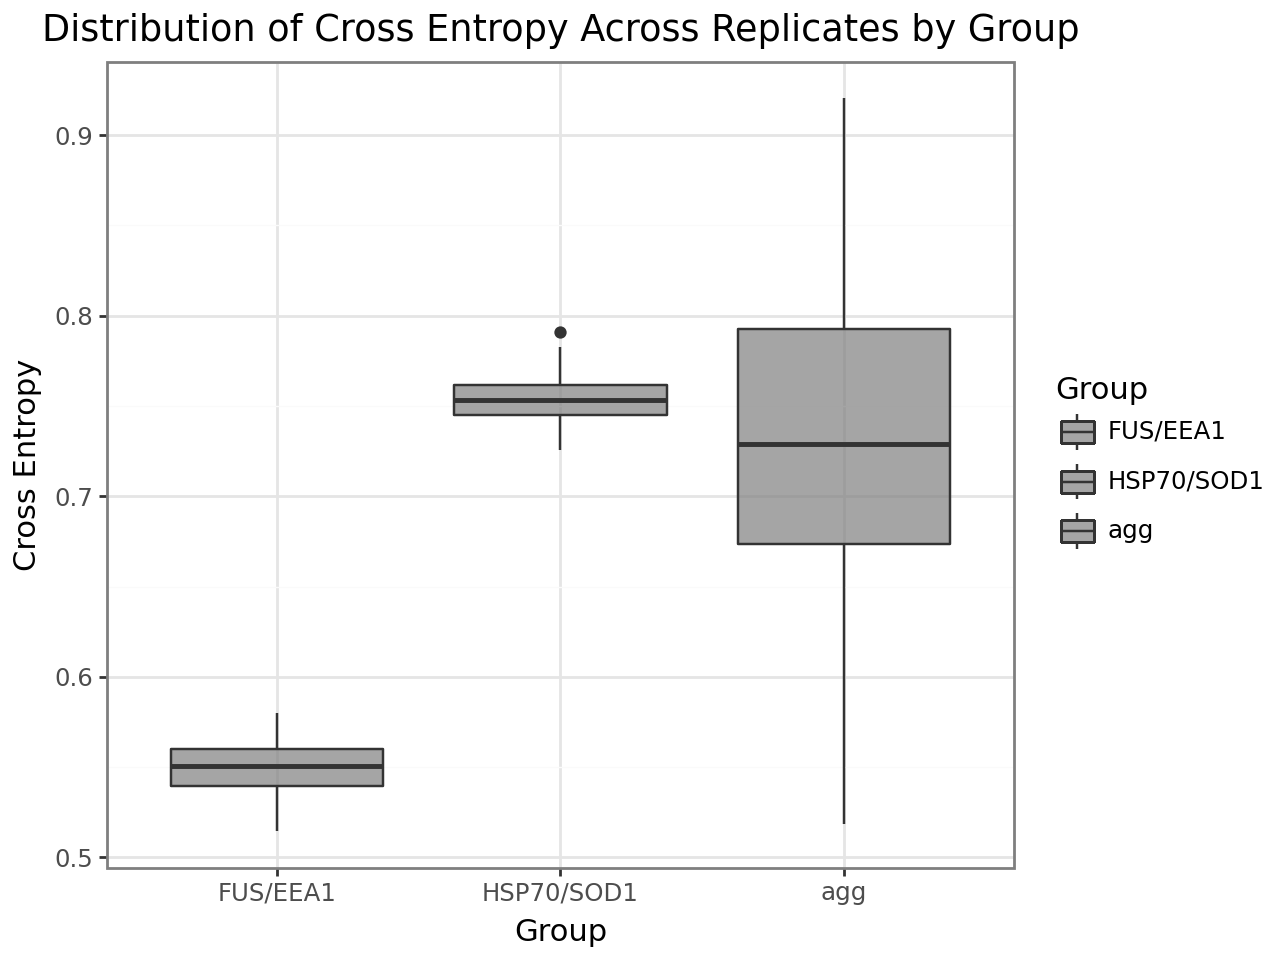

Stability Analysis Summary:
                            mean     std     min     max
group      metric                                       
FUS/EEA1   accuracy       0.6840  0.0366  0.5600  0.7200
           cross_entropy  0.5499  0.0138  0.5146  0.5802
HSP70/SOD1 accuracy       0.4000  0.0542  0.2800  0.5600
           cross_entropy  0.7533  0.0129  0.7258  0.7911
agg        accuracy       0.6828  0.0459  0.5600  0.8000
           cross_entropy  0.7325  0.0868  0.5184  0.9205


In [2]:
# Load and plot stability analysis results
import os
from plotnine import ggplot, aes, geom_boxplot, labs, ggtitle, theme_bw, scale_fill_manual
from maps.figures import PALETTE

# Load stability results if they exist
stability_file = "/home/kkumbier/maps/template_analyses/multimarker_stability_results.csv"

if os.path.exists(stability_file):
    stability_df = pd.read_csv(stability_file)
    
    # Plot accuracy distributions as boxplots
    accuracy_data = stability_df[stability_df['metric'] == 'accuracy']
    p_accuracy = (
        ggplot(accuracy_data, aes(x='group', y='value', fill='group')) +
        geom_boxplot(alpha=0.7) +
        labs(x='Group', y='Accuracy', fill='Group') +
        ggtitle('Distribution of Accuracy Across Replicates by Group') +
        scale_fill_manual(values=PALETTE) +
        theme_bw()
    )
    display(p_accuracy)
    
    # Plot cross entropy distributions as boxplots
    ce_data = stability_df[stability_df['metric'] == 'cross_entropy']
    p_ce = (
        ggplot(ce_data, aes(x='group', y='value', fill='group')) +
        geom_boxplot(alpha=0.7) +
        labs(x='Group', y='Cross Entropy', fill='Group') +
        ggtitle('Distribution of Cross Entropy Across Replicates by Group') +
        scale_fill_manual(values=PALETTE) +
        theme_bw()
    )
    display(p_ce)
    
    # Print summary statistics
    print("Stability Analysis Summary:")
    summary_stats = stability_df.groupby(['group', 'metric'])['value'].agg(['mean', 'std', 'min', 'max']).round(4)
    print(summary_stats)
    
else:
    print(f"Stability results file not found: {stability_file}")
    print("Run the stability analysis first using multimarker_binary_stability.py")

# Grid Search Analysis

This section analyzes the results from the comprehensive grid search over model architectures (n_layers: {0, 1, 2} × d_model: {8, 16, 32}) with 20 replicates each.

In [17]:
# Load grid search results
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

from plotnine import (
    ggplot, aes, geom_boxplot, geom_bar, geom_errorbar,
    facet_wrap, labs, ggtitle, theme_bw, theme, element_text,
    scale_fill_manual, position_dodge
)

# Load grid search results if they exist
base_dir = Path("/home/kkumbier/maps/template_analyses/")
grid_results_file = base_dir / "multimarker_grid_search_results.csv"
grid_predictions_file = base_dir / "multimarker_grid_search_predictions.csv"

if os.path.exists(grid_results_file) and os.path.exists(grid_predictions_file):
    grid_results = pd.read_csv(grid_results_file)
    grid_predictions = pd.read_csv(grid_predictions_file)
    
    print(f"Grid search results shape: {grid_results.shape}")
    print(f"Grid search predictions shape: {grid_predictions.shape}")
    
    # Display first few rows
    print("\nGrid Results Sample:")
    print(grid_results.head())
    
    print("\nGrid Predictions Sample:")
    print(grid_predictions.head())
    
else:
    print("Grid search files not found")
    grid_results = None
    grid_predictions = None

Grid search results shape: (1620, 7)
Grid search predictions shape: (4500, 12)

Grid Results Sample:
   replicate       group         metric     value  random_seed  n_layers  \
0          1         agg       accuracy  0.760000            0         0   
1          1         agg  cross_entropy  0.658519            0         0   
2          1         agg            auc  0.858974            0         0   
3          1  HSP70/SOD1       accuracy  0.400000            0         0   
4          1  HSP70/SOD1  cross_entropy  0.766587            0         0   

   d_model  
0        8  
1        8  
2        8  
3        8  
4        8  

Grid Predictions Sample:
   class_0_agg  class_1_agg  class_0_FUS/EEA1  class_1_FUS/EEA1  \
0     0.990546     0.009454          0.747239          0.252761   
1     0.950563     0.049437          0.697910          0.302090   
2     0.897755     0.102245          0.581629          0.418371   
3     0.968411     0.031589          0.832395          0.167605   
4  

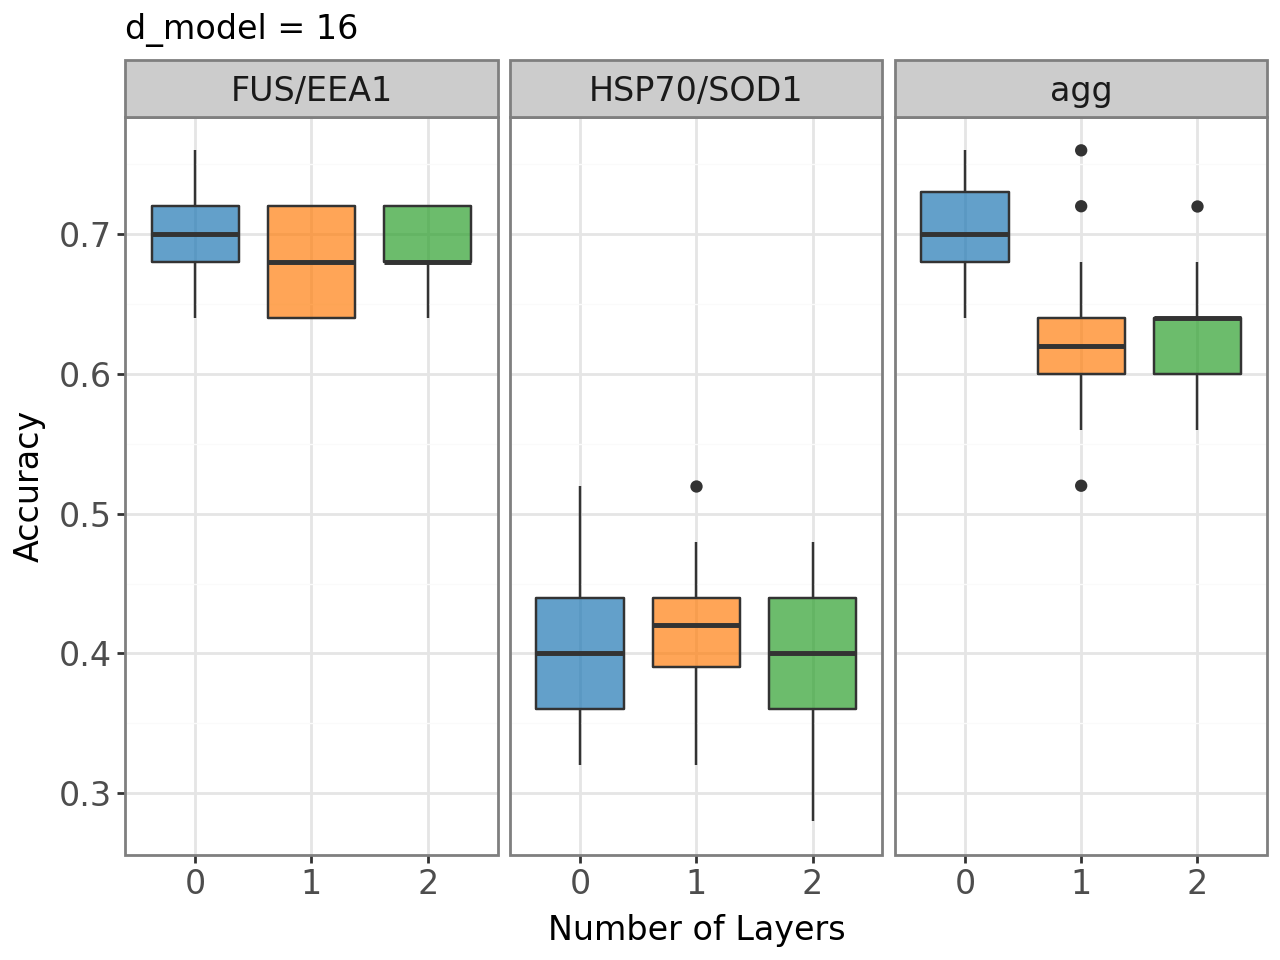

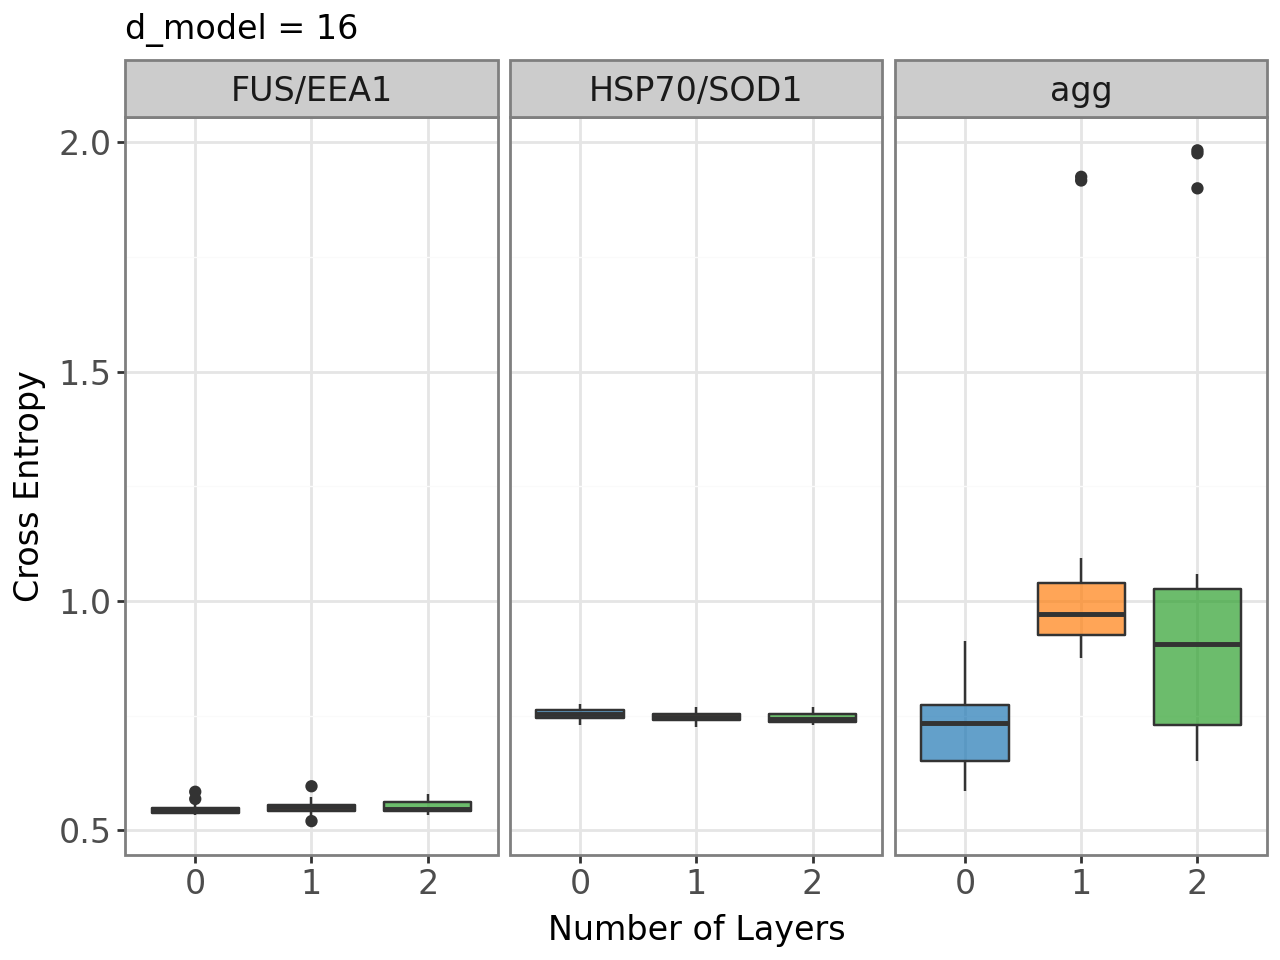

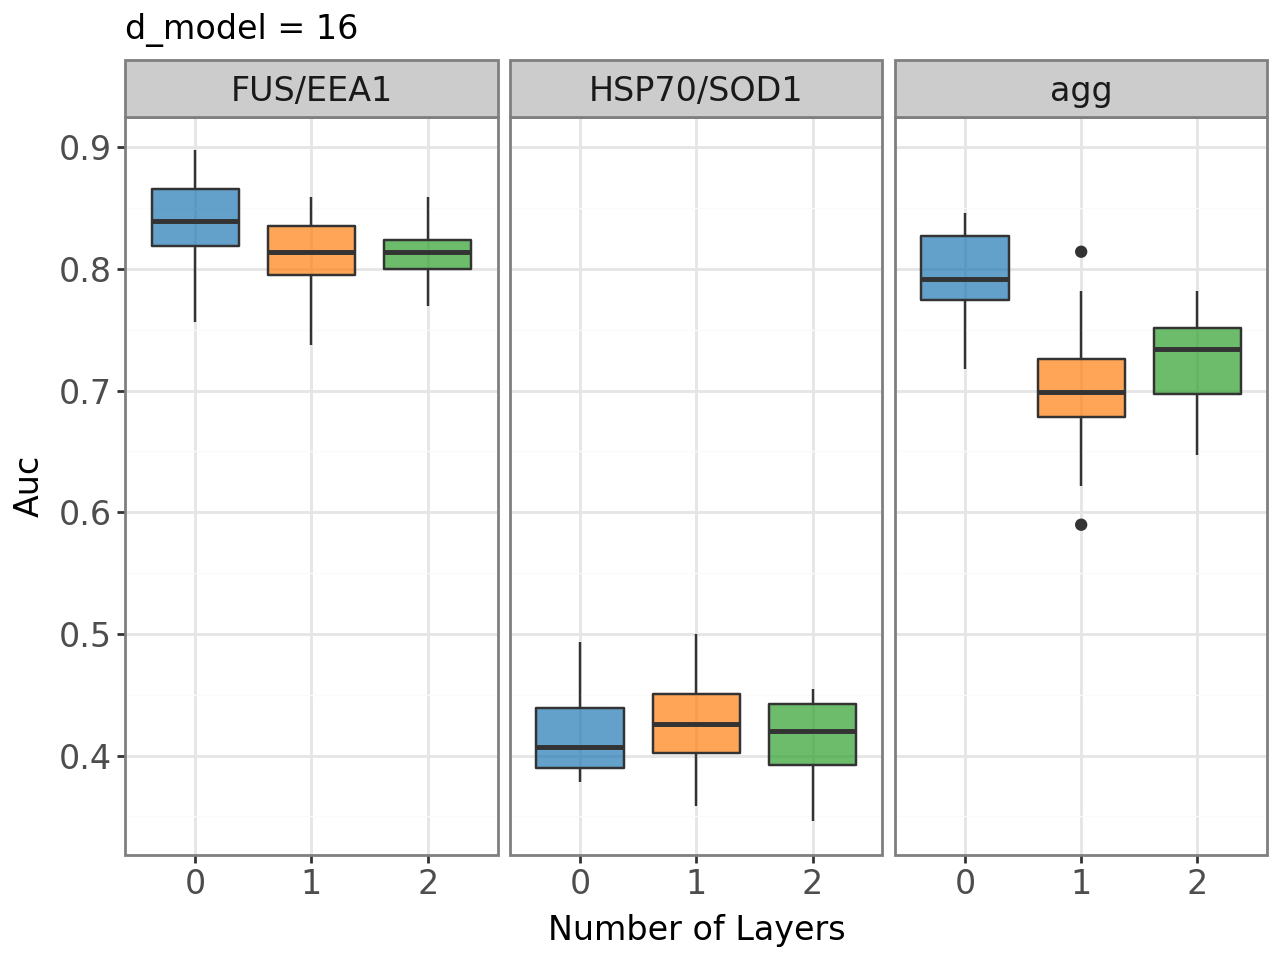

In [30]:
## Performance by Model Depth (n_layers)
if grid_results is not None:
    # Create plots comparing metrics by n_layers (filtered to d_model = 16)
    for metric in ['accuracy', 'cross_entropy', 'auc']:
        metric_data = grid_results[(grid_results['metric'] == metric) & (grid_results['d_model'] == 16)]
        
        p = (
            ggplot(metric_data, aes(x='factor(n_layers)', y='value', fill='factor(n_layers)')) +
            geom_boxplot(alpha=0.7) +
            facet_wrap('~group') +
            labs(x='Number of Layers', y=metric.replace('_', ' ').title(), fill='Layers',
                 subtitle='d_model = 16') +
            scale_fill_manual(values=['#1f77b4', '#ff7f0e', '#2ca02c']) +
            theme_bw() +
            theme(axis_text_x=element_text(rotation=0), legend_position="none", text=element_text(size=12))
        )
        display(p)

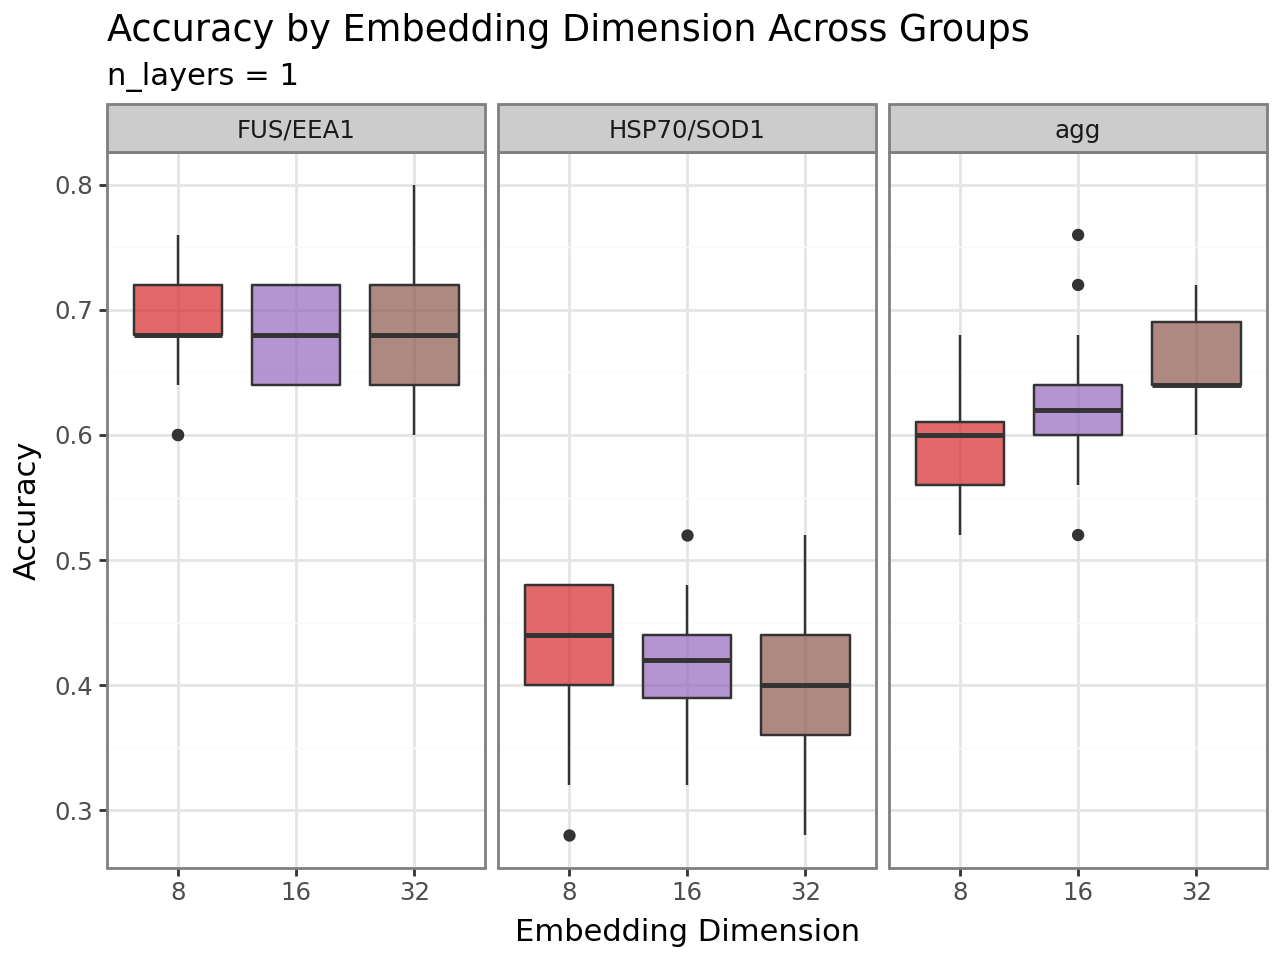

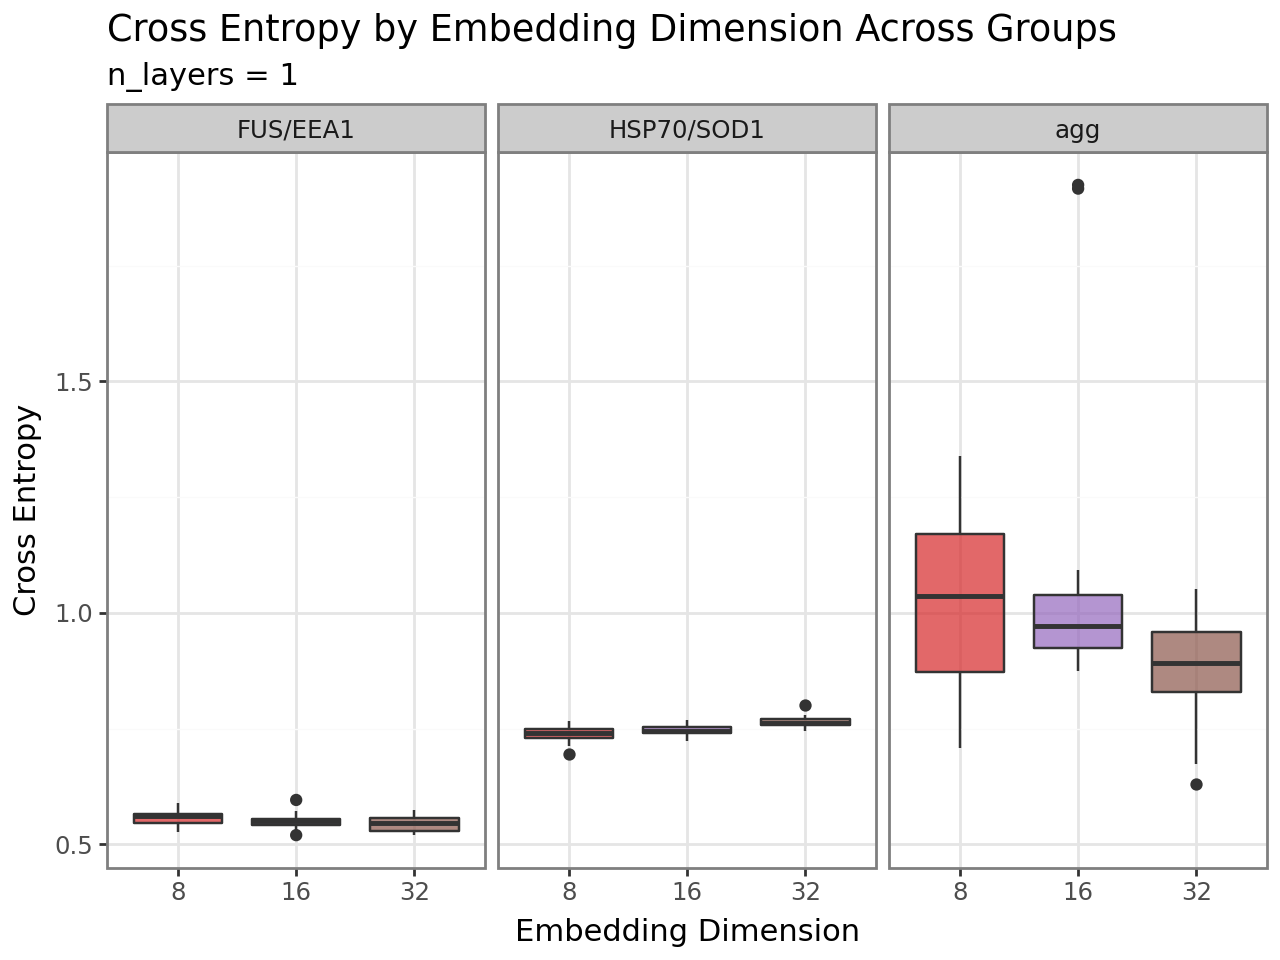

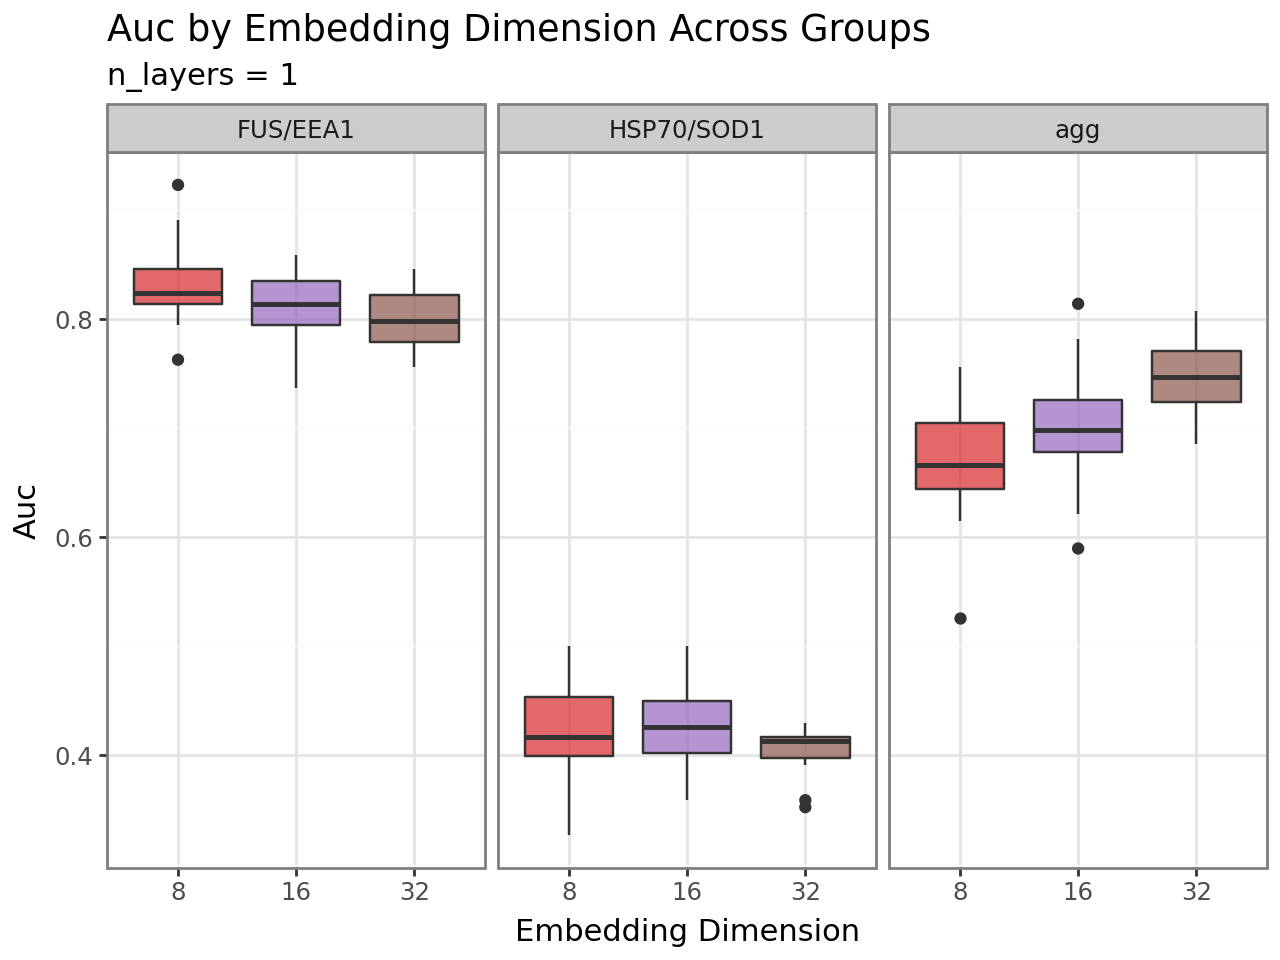

In [22]:
## Performance by Embedding Dimension (d_model)

if grid_results is not None:
    # Create plots comparing metrics by d_model (filtered to n_layers = 1)
    for metric in ['accuracy', 'cross_entropy', 'auc']:
        metric_data = grid_results[(grid_results['metric'] == metric) & (grid_results['n_layers'] == 1)]
        
        p = (
            ggplot(metric_data, aes(x='factor(d_model)', y='value', fill='factor(d_model)')) +
            geom_boxplot(alpha=0.7) +
            facet_wrap('~group') +
            labs(x='Embedding Dimension', y=metric.replace('_', ' ').title(), fill='d_model',
                 subtitle='n_layers = 1') +
            ggtitle(f'{metric.replace("_", " ").title()} by Embedding Dimension Across Groups') +
            scale_fill_manual(values=['#d62728', '#9467bd', '#8c564b']) +
            theme_bw() +
            theme(axis_text_x=element_text(rotation=0), legend_position="none")
        )
        display(p)
        

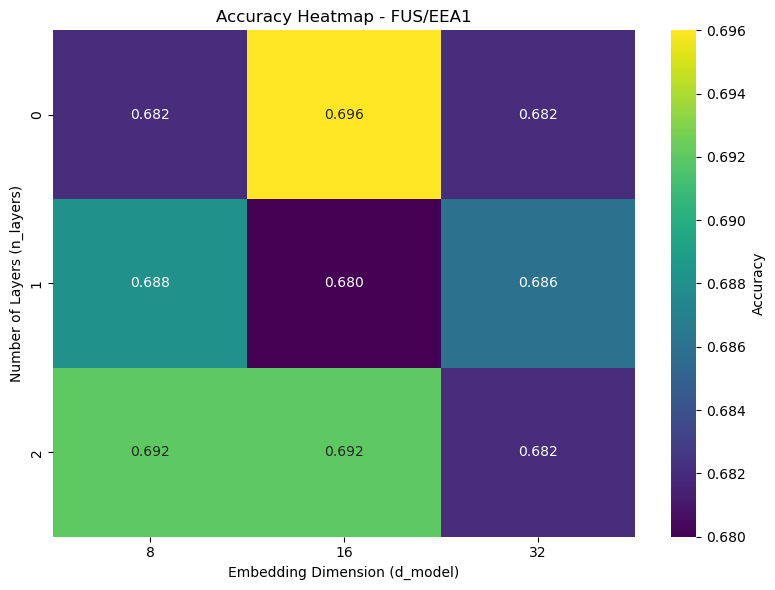

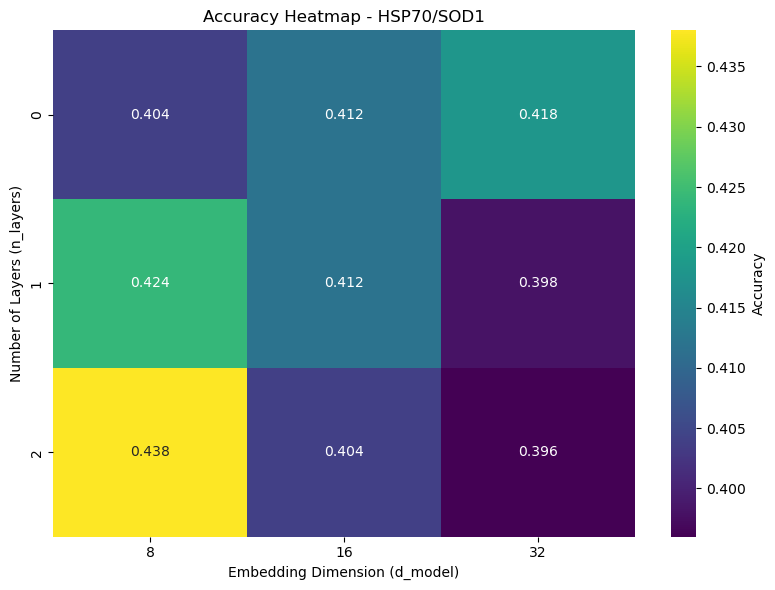

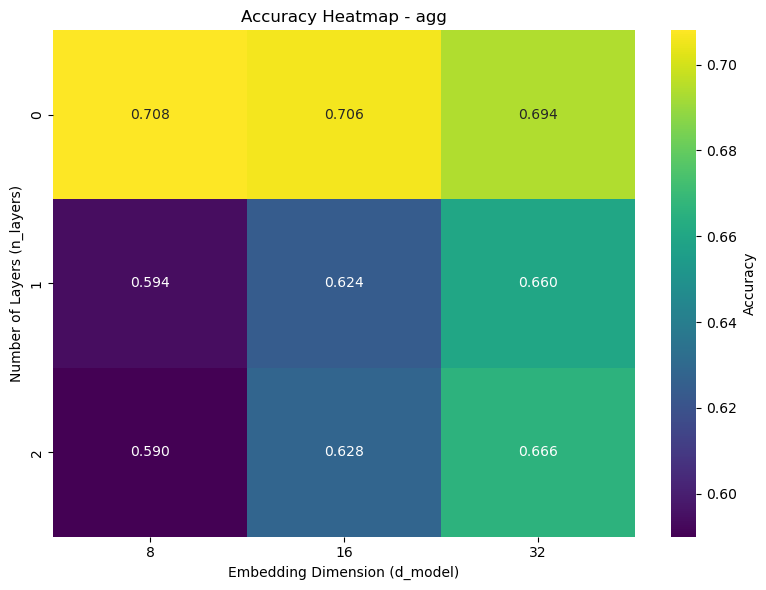

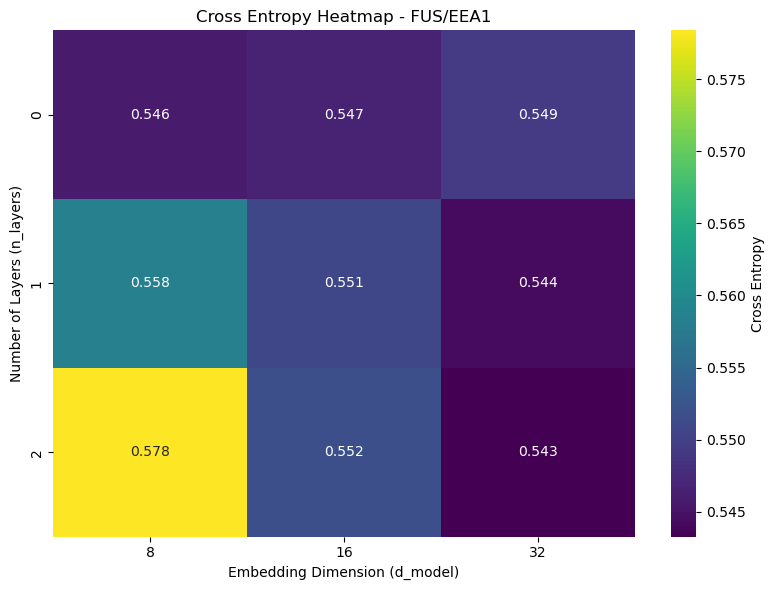

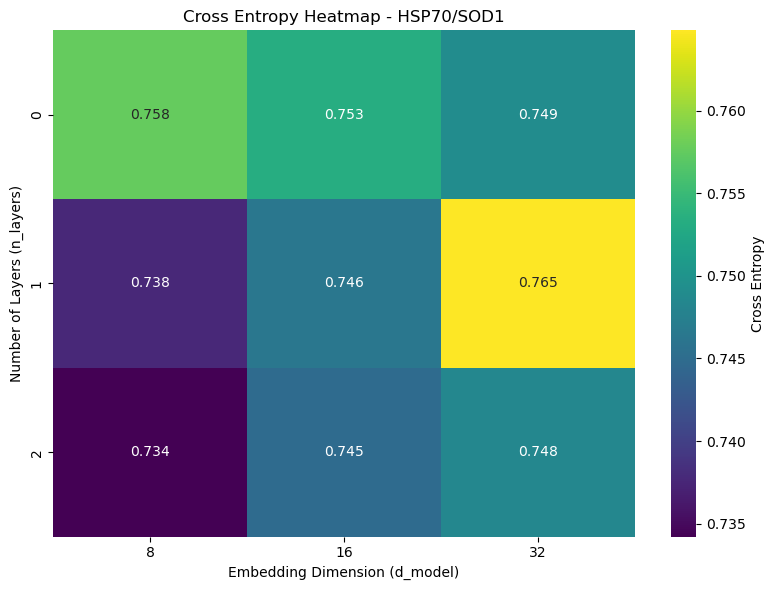

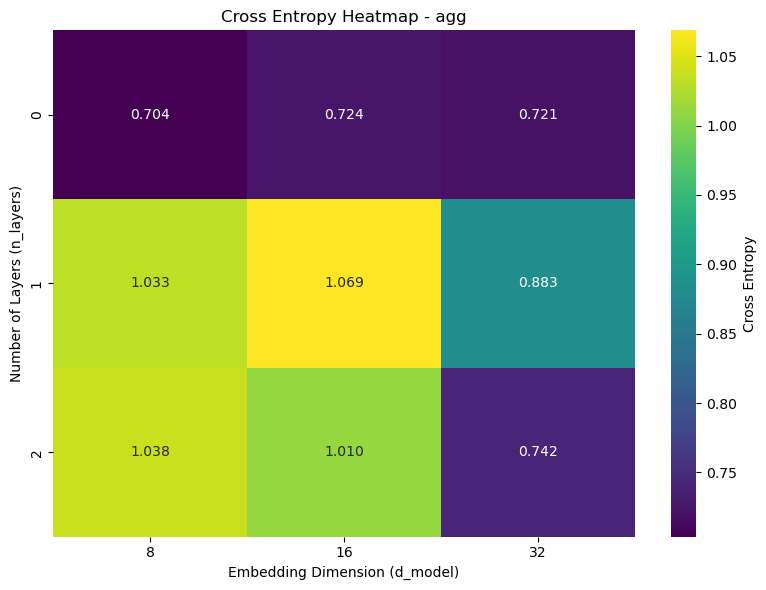

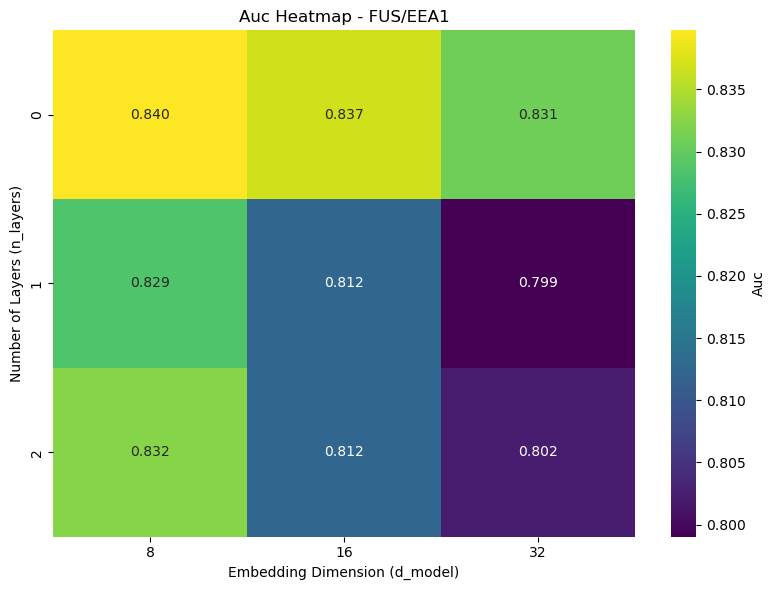

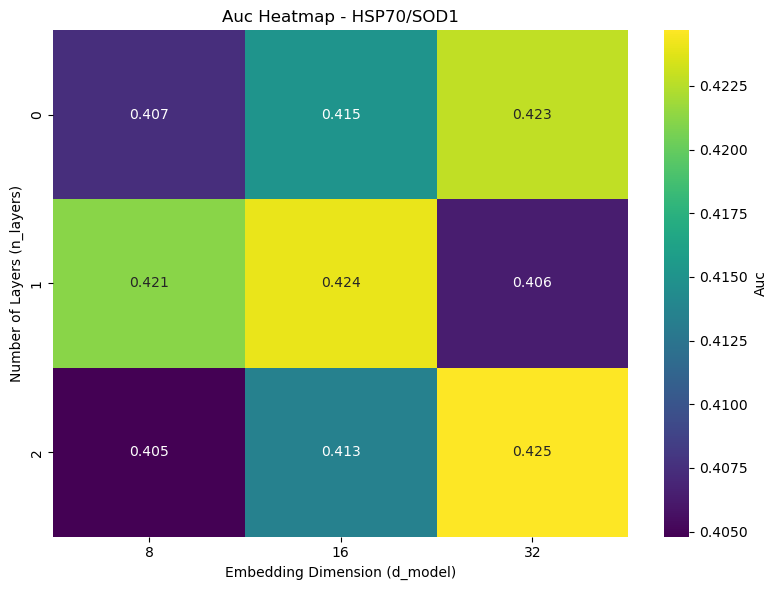

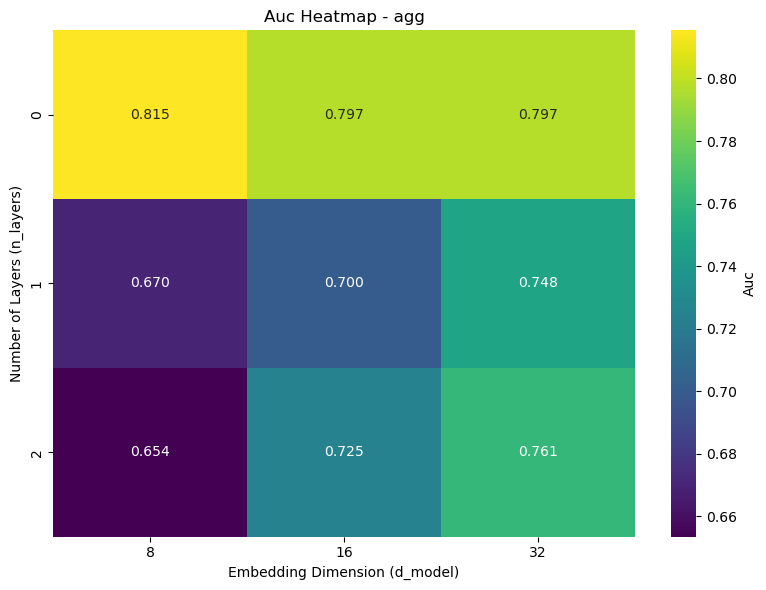

In [6]:
## Parameter Interaction Heatmaps

if grid_results is not None:
    # Create heatmaps showing interaction between n_layers and d_model
    for metric in ['accuracy', 'cross_entropy', 'auc']:
        metric_data = grid_results[grid_results['metric'] == metric]
        
        # Calculate mean performance for each parameter combination and group
        heatmap_data = metric_data.groupby(['n_layers', 'd_model', 'group'])['value'].mean().reset_index()
        
        # Create separate heatmap for each group
        for group in heatmap_data['group'].unique():
            group_data = heatmap_data[heatmap_data['group'] == group]
            
            # Pivot for heatmap
            heatmap_pivot = group_data.pivot(index='n_layers', columns='d_model', values='value')
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(heatmap_pivot, annot=True, fmt='.3f', cmap='viridis', 
                       cbar_kws={'label': metric.replace('_', ' ').title()})
            plt.title(f'{metric.replace("_", " ").title()} Heatmap - {group}')
            plt.xlabel('Embedding Dimension (d_model)')
            plt.ylabel('Number of Layers (n_layers)')
            plt.tight_layout()
            plt.show()

Cell Line Classifications:
  11: WT
  ALS1: WT
  ALS15: WT
  ALS18: WT
  ALS20: WT
  ALS24: WT
  CRL-2201: WT
  CRL-2510: WT
  FTD37: WT
  FTD75: WT
  GIH-130: FUS
  GIH158: WT
  GIH166: WT
  ND29563: FUS
  ND39027: FUS
  ND40077: FUS
  NS002: FUS
  NS003: FUS
  NS020: FUS
  NS030: FUS
  NS034: FUS
  NS044: FUS
  NS046: FUS
  SS2031: FUS
  SS2032: FUS


/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_errorbar : Removed 6 rows containing missing values.


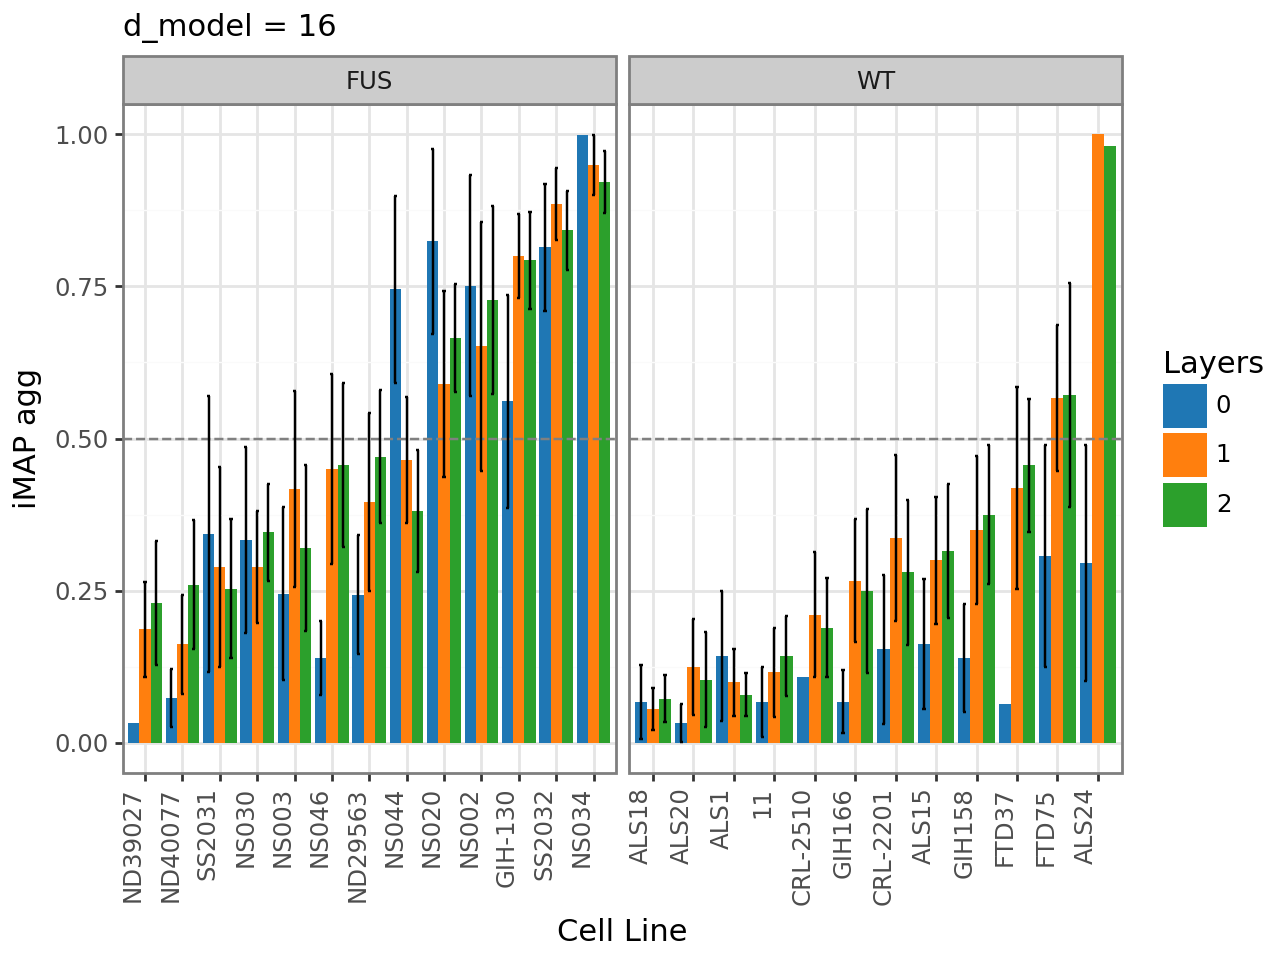

/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_errorbar : Removed 3 rows containing missing values.


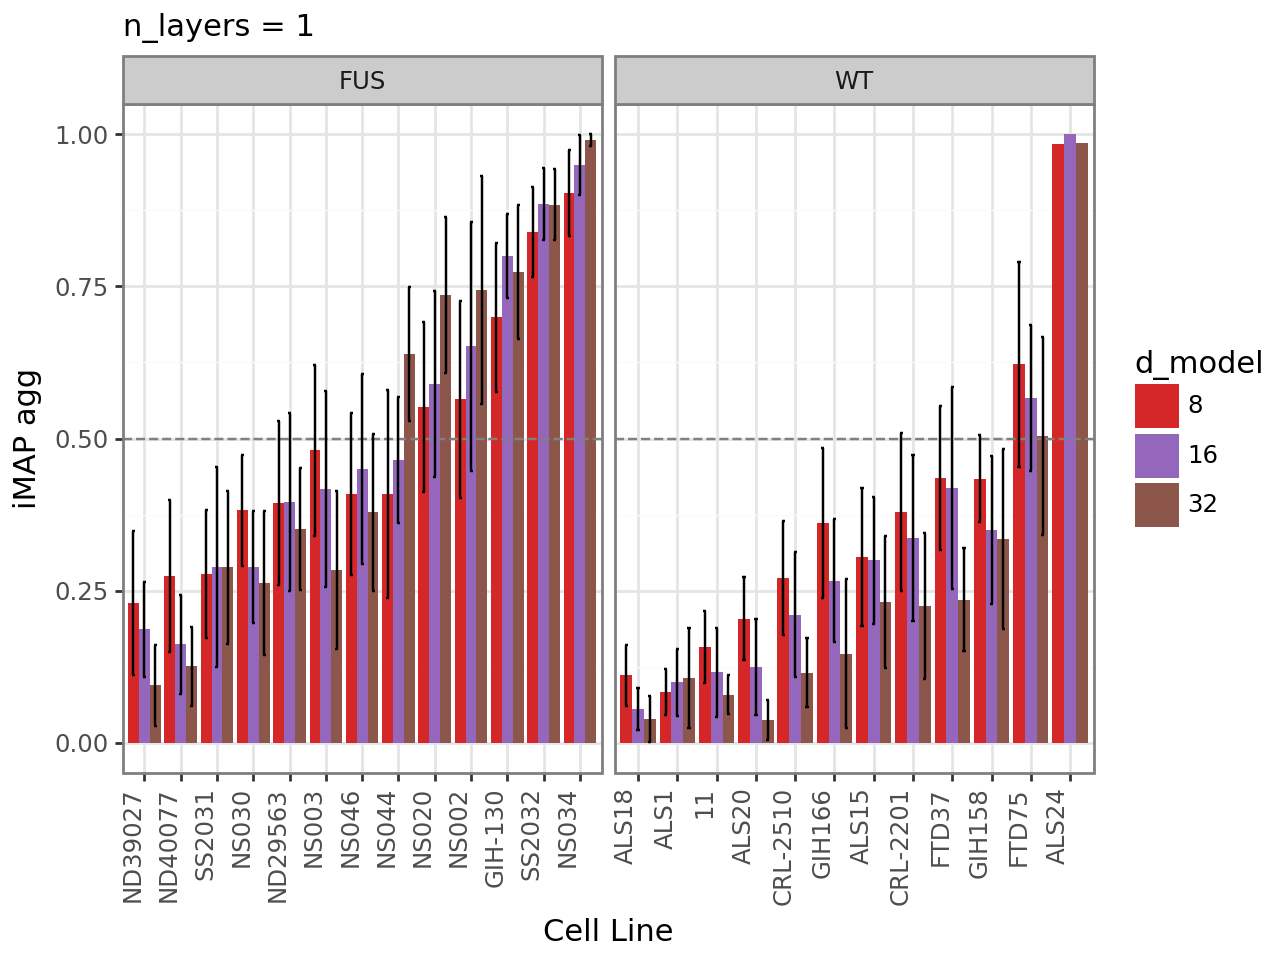

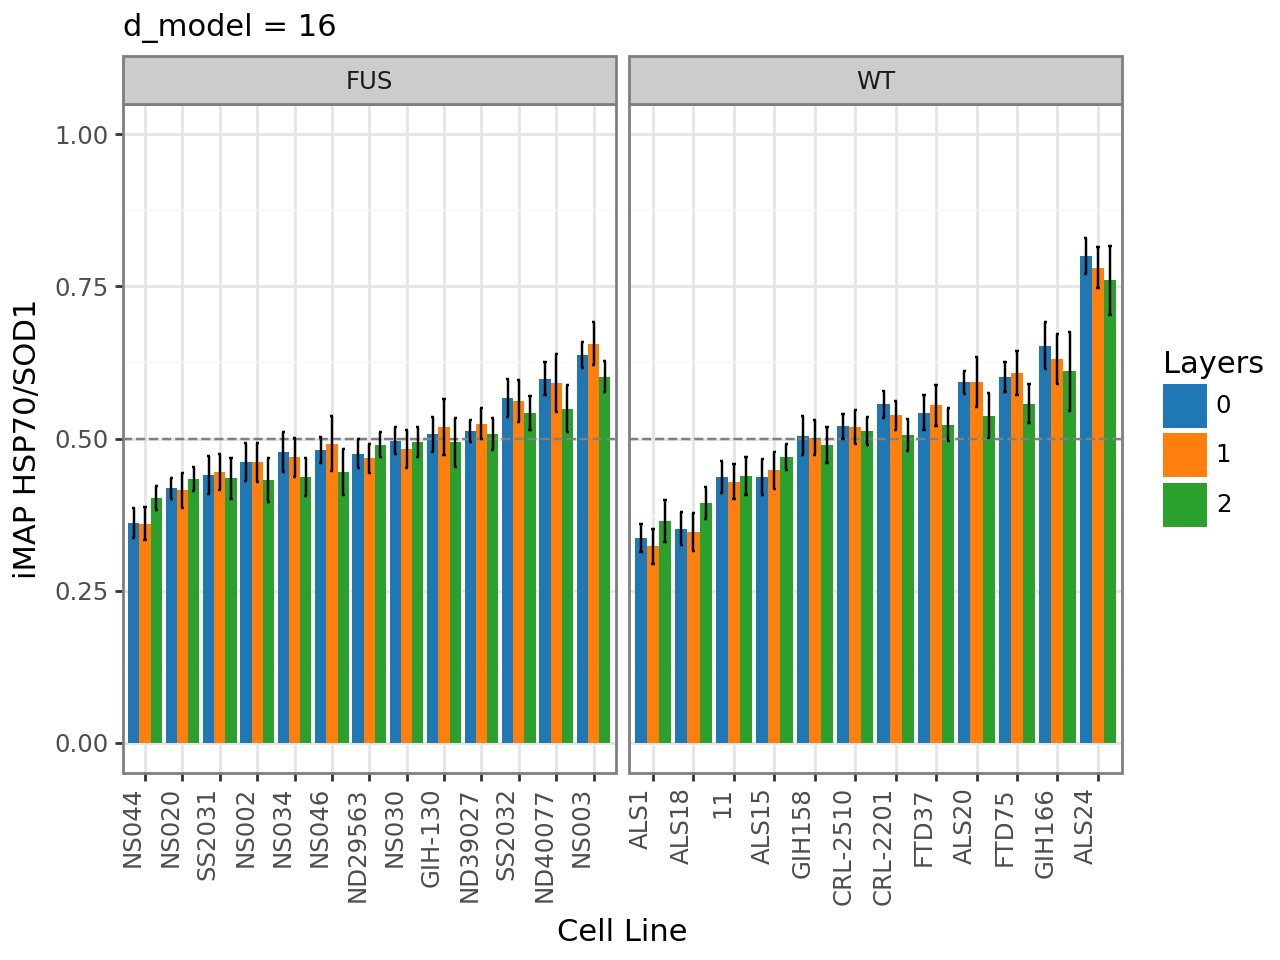

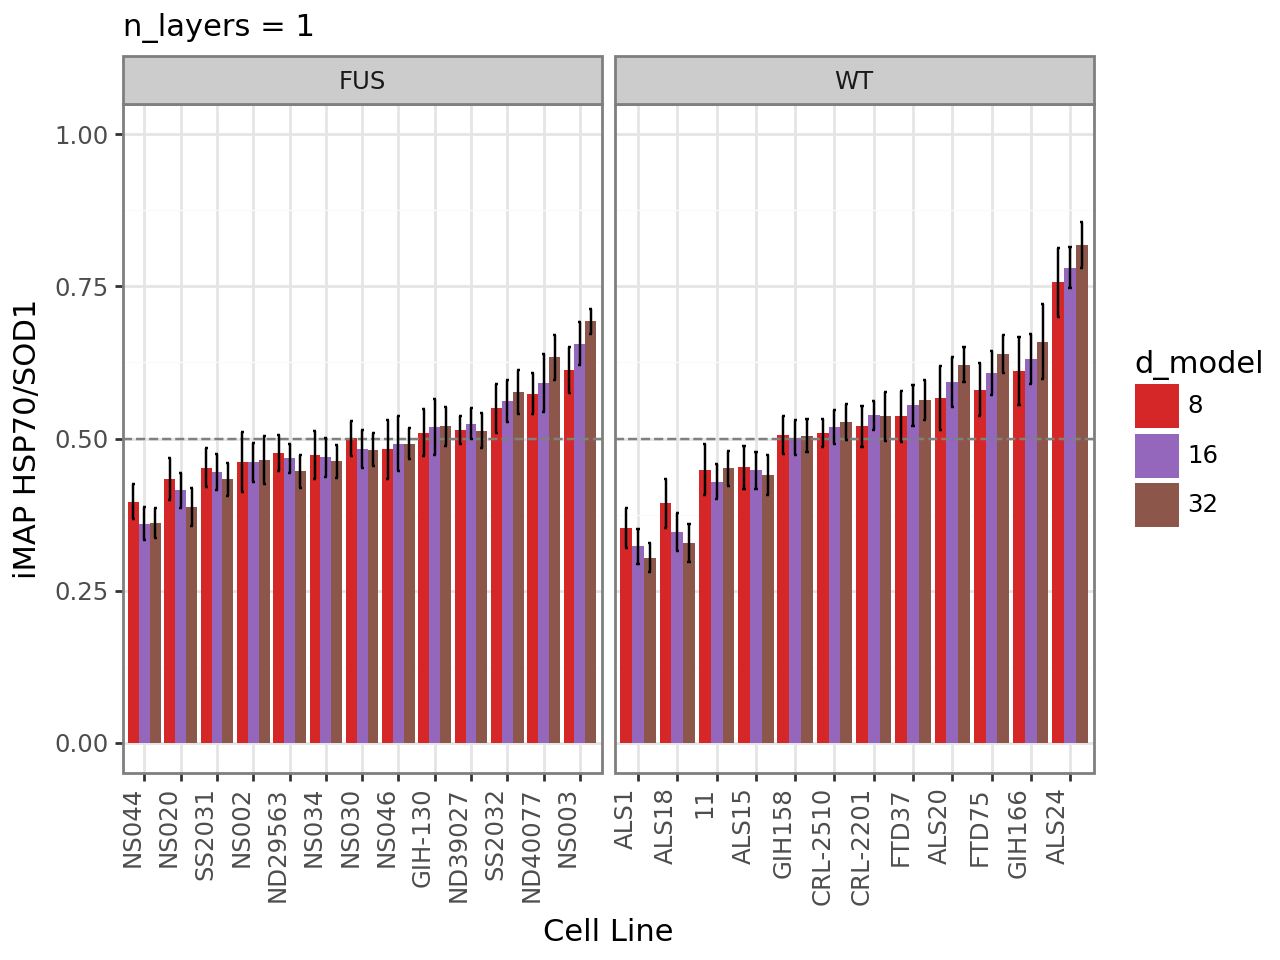

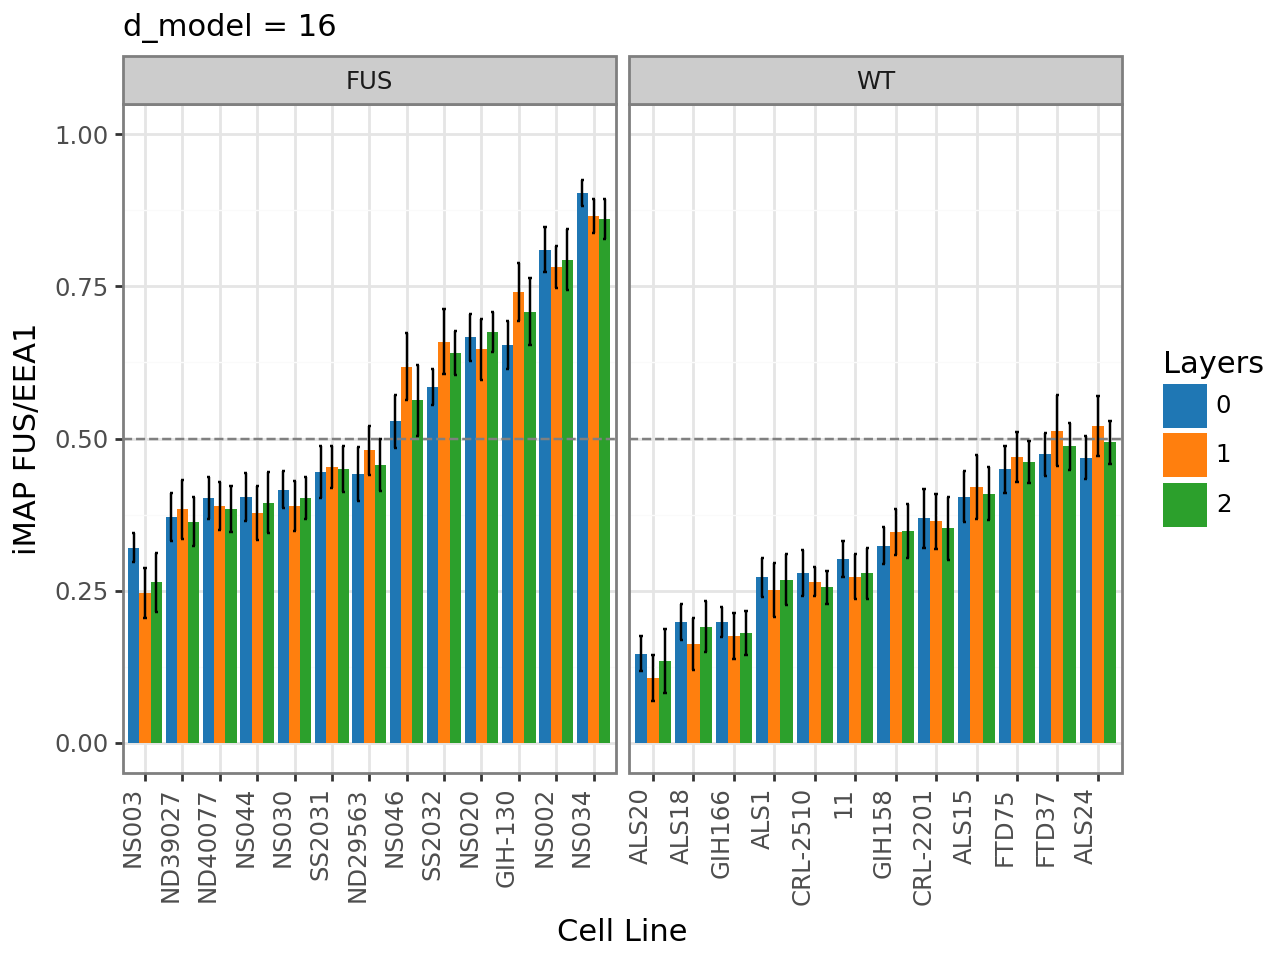

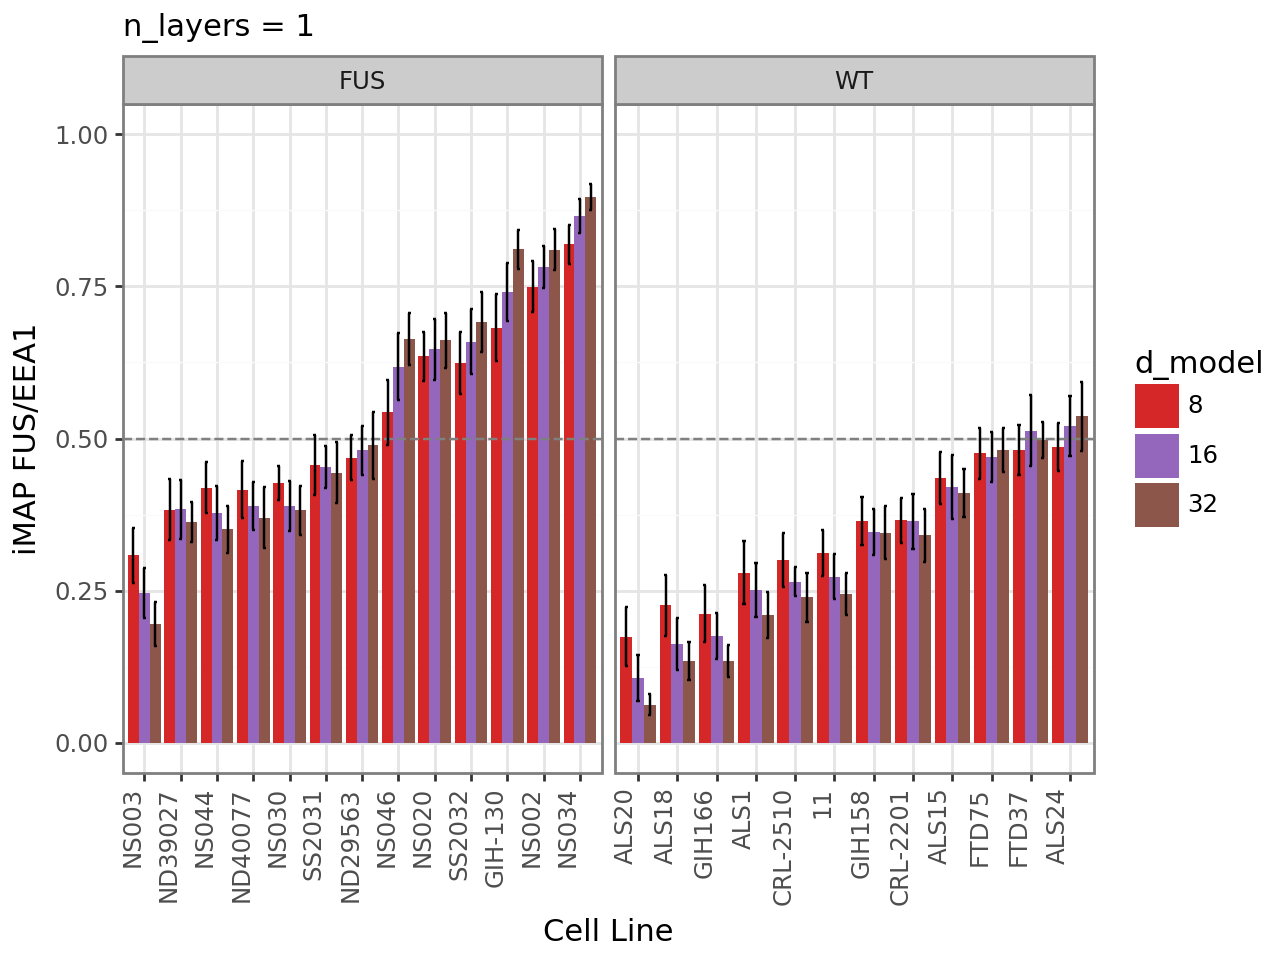

In [29]:
from plotnine import geom_hline, ylim
## Cell Line Predictions Analysis

if grid_predictions is not None:
    # Define cell line classifications (you may need to adjust these based on your data)
    cell_line_classes = {}
    
    # Try to infer from True labels if available
    if 'True' in grid_predictions.columns:
        for cell_line in grid_predictions['CellLines'].unique():
            cell_line_data = grid_predictions[grid_predictions['CellLines'] == cell_line]
            most_common_class = cell_line_data['True'].mode().iloc[0] if len(cell_line_data['True'].mode()) > 0 else 0
            cell_line_classes[cell_line] = 'FUS' if most_common_class == 1 else 'WT'
    else:
        # Fallback classification (update based on your knowledge)
        for cell_line in grid_predictions['CellLines'].unique():
            cell_line_classes[cell_line] = 'Unknown'
    
    print("Cell Line Classifications:")
    for cell_line, classification in cell_line_classes.items():
        print(f"  {cell_line}: {classification}")
    
    # Calculate mean and standard deviation of predictions by cell line and parameters
    groups = ["agg"] + antibodies
    
    for group in groups:
        if f'class_1_{group}' in grid_predictions.columns:
            # Create summary statistics for predictions
            pred_summary = grid_predictions.groupby(['CellLines', 'n_layers', 'd_model']).agg({
                f'class_1_{group}': ['mean', 'std', 'count']
            }).reset_index()
            
            # Flatten column names
            pred_summary.columns = ['CellLines', 'n_layers', 'd_model', 'mean_pred', 'std_pred', 'count']
            
            # Add cell line classification
            pred_summary['cell_class'] = pred_summary['CellLines'].map(cell_line_classes)
            
            # Plot by n_layers (fix d_model = 16)
            depth_data = pred_summary[pred_summary['d_model'] == 16].copy()
            if not depth_data.empty:
                # Order cell lines by average prediction value
                cell_order = depth_data.groupby('CellLines')['mean_pred'].mean().sort_values().index.tolist()
                depth_data['CellLines'] = pd.Categorical(depth_data['CellLines'], categories=cell_order, ordered=True)
                
                p1 = (
                    ggplot(depth_data, aes(x='CellLines', y='mean_pred', fill='factor(n_layers)')) +
                    geom_bar(stat='identity', position='dodge') +
                    geom_hline(yintercept=0.5, linetype='dashed', color='grey') +
                    geom_errorbar(aes(ymin='mean_pred - std_pred', ymax='mean_pred + std_pred'), 
                                 position=position_dodge(width=0.9), width=0.25) +
                    facet_wrap('~cell_class', scales='free_x') +
                    labs(x='Cell Line', y=f'iMAP {(group)}', fill='Layers',
                         subtitle='d_model = 16') +
                    scale_fill_manual(values=['#1f77b4', '#ff7f0e', '#2ca02c']) +
                    theme_bw() +
                    ylim(0, 1) +
                    theme(axis_text_x=element_text(rotation=90, hjust=1))
                )
                display(p1)
            
            # Plot by d_model (fix n_layers = 1)
            dim_data = pred_summary[pred_summary['n_layers'] == 1].copy()
            if not dim_data.empty:
                # Order cell lines by average prediction value
                cell_order = dim_data.groupby('CellLines')['mean_pred'].mean().sort_values().index.tolist()
                dim_data['CellLines'] = pd.Categorical(dim_data['CellLines'], categories=cell_order, ordered=True)
                
                p2 = (
                    ggplot(dim_data, aes(x='CellLines', y='mean_pred', fill='factor(d_model)')) +
                    geom_bar(stat='identity', position='dodge') +
                    geom_hline(yintercept=0.5, linetype='dashed', color='grey') +
                    geom_errorbar(aes(ymin='mean_pred - std_pred', ymax='mean_pred + std_pred'), 
                                 position=position_dodge(width=0.9), width=0.25) +
                    facet_wrap('~cell_class', scales='free_x') +
                    labs(x='Cell Line', y=f'iMAP {(group)}', fill='d_model',
                         subtitle='n_layers = 1') +
                    scale_fill_manual(values=['#d62728', '#9467bd', '#8c564b']) +
                    theme_bw() +
                    ylim(0, 1) +
                    theme(axis_text_x=element_text(rotation=90, hjust=1))
                )
                display(p2)

In [15]:
## Best Parameter Combinations

if grid_results is not None:
    # Find best parameter combinations for each metric and group
    print("Best Parameter Combinations by Metric and Group:")
    print("=" * 60)
    
    for metric in ['accuracy', 'auc']:  # Higher is better
        metric_data = grid_results[grid_results['metric'] == metric]
        best_params = metric_data.groupby(['group', 'n_layers', 'd_model'])['value'].mean().reset_index()
        
        for group in best_params['group'].unique():
            group_data = best_params[best_params['group'] == group]
            best_row = group_data.loc[group_data['value'].idxmax()]
            
            print(f"\n{metric.upper()} - {group}:")
            print(f"  Best: n_layers={int(best_row['n_layers'])}, d_model={int(best_row['d_model'])}")
            print(f"  Score: {best_row['value']:.4f}")
    
    # For cross entropy, lower is better
    ce_data = grid_results[grid_results['metric'] == 'cross_entropy']
    best_ce = ce_data.groupby(['group', 'n_layers', 'd_model'])['value'].mean().reset_index()
    
    for group in best_ce['group'].unique():
        group_data = best_ce[best_ce['group'] == group]
        best_row = group_data.loc[group_data['value'].idxmin()]
        
        print(f"\nCROSS_ENTROPY - {group}:")
        print(f"  Best: n_layers={int(best_row['n_layers'])}, d_model={int(best_row['d_model'])}")
        print(f"  Score: {best_row['value']:.4f}")
    
    # Overall ranking based on accuracy
    print("\n" + "=" * 60)
    print("OVERALL RANKING (by Accuracy):")
    accuracy_data = grid_results[grid_results['metric'] == 'accuracy']
    overall_ranking = accuracy_data.groupby(['n_layers', 'd_model'])['value'].mean().reset_index()
    overall_ranking = overall_ranking.sort_values('value', ascending=False)
    
    for i, row in overall_ranking.iterrows():
        print(f"{i+1}. n_layers={int(row['n_layers'])}, d_model={int(row['d_model'])}: {row['value']:.4f}")

Best Parameter Combinations by Metric and Group:

ACCURACY - FUS/EEA1:
  Best: n_layers=0, d_model=16
  Score: 0.6960

ACCURACY - HSP70/SOD1:
  Best: n_layers=2, d_model=8
  Score: 0.4380

ACCURACY - agg:
  Best: n_layers=0, d_model=8
  Score: 0.7080

AUC - FUS/EEA1:
  Best: n_layers=0, d_model=8
  Score: 0.8397

AUC - HSP70/SOD1:
  Best: n_layers=2, d_model=32
  Score: 0.4247

AUC - agg:
  Best: n_layers=0, d_model=8
  Score: 0.8154

CROSS_ENTROPY - FUS/EEA1:
  Best: n_layers=2, d_model=32
  Score: 0.5433

CROSS_ENTROPY - HSP70/SOD1:
  Best: n_layers=2, d_model=8
  Score: 0.7342

CROSS_ENTROPY - agg:
  Best: n_layers=0, d_model=8
  Score: 0.7038

OVERALL RANKING (by Accuracy):
2. n_layers=0, d_model=16: 0.6047
1. n_layers=0, d_model=8: 0.5980
3. n_layers=0, d_model=32: 0.5980
9. n_layers=2, d_model=32: 0.5813
6. n_layers=1, d_model=32: 0.5813
8. n_layers=2, d_model=16: 0.5747
7. n_layers=2, d_model=8: 0.5733
5. n_layers=1, d_model=16: 0.5720
4. n_layers=1, d_model=8: 0.5687
